In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

#  Define Dataset Size
num_players = 100_000  # 100K unique players
num_days = 365  # Data for 1 year
max_levels = 100  # Levels range from 1 to 100

#  Generate Player IDs
player_ids = [f"player_{i}" for i in range(num_players)]

#  Generate Start Dates for Players
start_dates = np.random.choice(pd.date_range("2023-01-01", "2023-12-31"), size=num_players)

#  Initialize Data
data = []

for player_id, start_date in zip(player_ids, start_dates):
    num_sessions = np.random.randint(5, 100)  # Each player plays multiple sessions
    session_dates = sorted(
        np.random.choice(pd.date_range(start_date, "2024-01-01"), size=num_sessions, replace=True)
    )

    # Assign **Player Skill** (affects level progression & churn)
    player_skill = np.random.uniform(0.1, 1.0)  # Higher skill → higher level, lower churn

    for session_date in session_dates:
        level = min(max_levels, int(1 + max_levels * player_skill * np.random.rand()))

        #  Session Timing (More Evening Playtime)
        hour_probs = np.array([0.02, 0.02, 0.01, 0.01, 0.02, 0.02, 0.03, 0.05, 0.08, 0.10,
                               0.12, 0.12, 0.10, 0.08, 0.08, 0.08, 0.07, 0.05, 0.03, 0.02,
                               0.02, 0.02, 0.01, 0.01])
        hour_probs /= hour_probs.sum()  # Normalize
        hour = int(np.random.choice(range(24), p=hour_probs))
        session_time = pd.Timestamp(session_date) + pd.to_timedelta(hour, unit="h") + pd.to_timedelta(np.random.randint(0, 60), unit="m")

        #  Adaptive Attempts Based on Difficulty & Skill
        base_attempts = np.random.randint(1, 20)
        num_attempts = max(1, int(base_attempts * (1.2 - player_skill)))
        num_success = max(0, int(np.random.uniform(0.3 + player_skill * 0.4, 1.0) * num_attempts))
        failed_first_attempt = 1 if num_success == 0 else 0

        #  **Session Length → Depends on Level & Attempts**
        session_length_minutes = max(1, np.random.normal(20 + level * 0.5 - player_skill * 10, 10))

        #  **Ad Clicks** → Struggling players watch more ads
        ad_clicks = np.random.poisson(1 if num_success > 0 else 4)  # Unsuccessful players click more ads

        #  **Booster Usage → Depends on Difficulty & Spending**
        booster_usage = np.random.randint(1, 4) if num_attempts > 10 and np.random.rand() < 0.5 else 0

        #  **Spending Model**
        made_purchase = np.random.choice([0, 1], p=[0.90, 0.10])  # 10% players make purchases
        power_up_purchase = np.random.choice([0, 1], p=[0.95, 0.05])

        # Spending Category (More skilled players tend to be spenders)
        if made_purchase:
            spender_category = np.random.choice(["Low-Spender", "High-Spender"], p=[0.8, 0.2])
        else:
            spender_category = "Non-Spender"

        # Append to dataset
        data.append([
            player_id, session_time, level, num_attempts, num_success, failed_first_attempt,
            session_length_minutes, made_purchase, spender_category, power_up_purchase,
            booster_usage, ad_clicks, player_skill
        ])

#  Create DataFrame
df = pd.DataFrame(data, columns=[
    "player_id", "dt", "level", "num_attempts", "num_success", "failed_first_attempt",
    "session_length_minutes", "made_purchase", "spender_category", "power_up_purchase",
    "booster_usage", "ad_clicks", "player_skill"
])

#  Compute Days Since First Play
df["dt"] = pd.to_datetime(df["dt"])
df["first_play_date"] = df.groupby("player_id")["dt"].transform("min")
df["days_since_first_play"] = (df["dt"] - df["first_play_date"]).dt.days

#  Compute Total Levels Played
df["total_levels_played"] = df.groupby("player_id")["level"].transform("nunique")

#  **Churn Model (Realistic Probabilities)**
engagement_score = df["num_attempts"] * 0.5 - df["session_length_minutes"] * 0.05 + df["player_skill"] * 2
churn_prob = np.clip(0.5 - (engagement_score / 50), 0.05, 0.9)  # Players with better engagement have lower churn

df["churned"] = np.random.binomial(1, churn_prob)

# **Day-wise & Month-wise Churn**
for d in range(1, 8):
    df[f"D{d}_churn"] = np.random.binomial(1, churn_prob * (0.9 - d * 0.1))  # Lower churn the longer they stay

for m in range(1, 13):
    df[f"M{m}_churn"] = np.random.binomial(1, churn_prob * (0.8 - m * 0.05))

#  **Sort & Save**
df = df.sort_values(by=["player_id", "dt"])
df.to_csv("realistic_synthetic_player_data.csv", index=False)

# Show Sample
print(df.head())



  player_id                  dt  level  num_attempts  num_success  \
0  player_0 2023-04-13 07:23:00      6            13           12   
1  player_0 2023-04-24 08:23:00     19             5            2   
2  player_0 2023-04-26 11:47:00     18             5            4   
3  player_0 2023-05-04 22:59:00     13             5            3   
5  player_0 2023-05-09 03:32:00      4             8            5   

   failed_first_attempt  session_length_minutes  made_purchase  \
0                     0               27.868874              0   
1                     0               23.387788              0   
2                     0               34.749714              0   
3                     0               38.766103              0   
5                     0               16.109370              0   

  spender_category  power_up_purchase  ...  M3_churn  M4_churn  M5_churn  \
0      Non-Spender                  0  ...         0         0         1   
1      Non-Spender                  

Goal:
We created a realistic synthetic dataset for player behavior and churn modeling over a year, incorporating gameplay, engagement, and spending behavior.

🔹 Step 1: Dataset Definition
Number of Players: 100,000
Time Span: 365 days (Jan 2023 - Dec 2023)
Game Levels: 1 to 100
Player IDs: Generated as player_0, player_1, ...
Start Dates: Randomly assigned
🔹 Step 2: Session-Level Data Generation
Each player has multiple sessions, where we simulate: 1️⃣ Skill-Based Level Progression → Skilled players progress faster.
2️⃣ Session Timing Bias → Most play sessions occur in the evening.
3️⃣ Attempt Success Rate → Dependent on player skill and level difficulty.
4️⃣ Ad Clicks & Booster Usage → Players struggling tend to watch more ads.
5️⃣ Session Length → Depends on difficulty, attempts, and engagement.
6️⃣ Spending Model → Players are low, high, or non-spenders.

🔹 Step 3: Engagement & Churn Simulation
Engagement Score Calculation → Combination of:
num_attempts
session_length_minutes
player_skill
Churn Probability Model:
Players with higher skill and engagement churn less.
Players with low engagement have a higher churn probability.
Day-wise & Month-wise Churn Labels:
D1_churn, D2_churn, ..., D7_churn
M1_churn, M2_churn, ..., M12_churn
Modeled progressive retention decay over time.
🔹 Step 4: Dataset Cleanup & Storage
1️⃣ Computed days since first play per player.
2️⃣ Computed total unique levels played.
3️⃣ Sorted & saved dataset to "realistic_synthetic_player_data.csv".

📊 Sample Output
player_id	date	level	num_attempts	session_length_minutes	player_skill	churned
player_0	2023-04-13 07:23:00	6	13	27.8	0.76	0
player_0	2023-04-24 08:23:00	19	5	23.3	0.45	1
player_1	2023-05-09 03:32:00	4	8	16.1	0.34	1


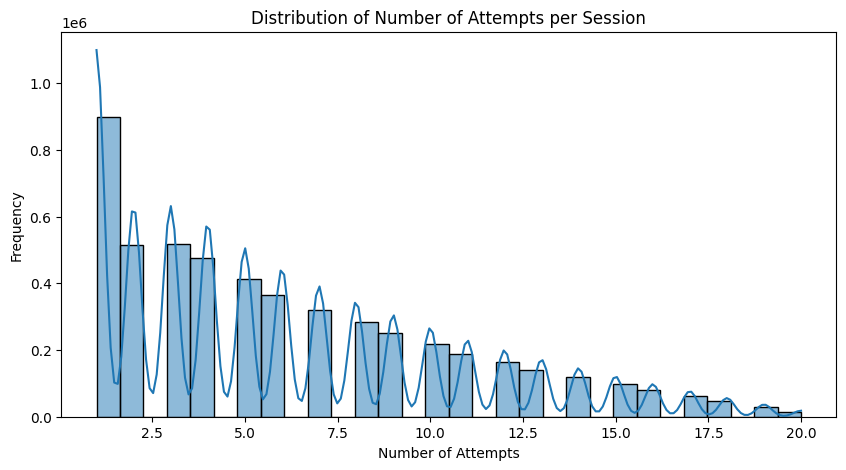

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(df['num_attempts'], bins=30, kde=True)
plt.xlabel('Number of Attempts')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Attempts per Session')
plt.show()


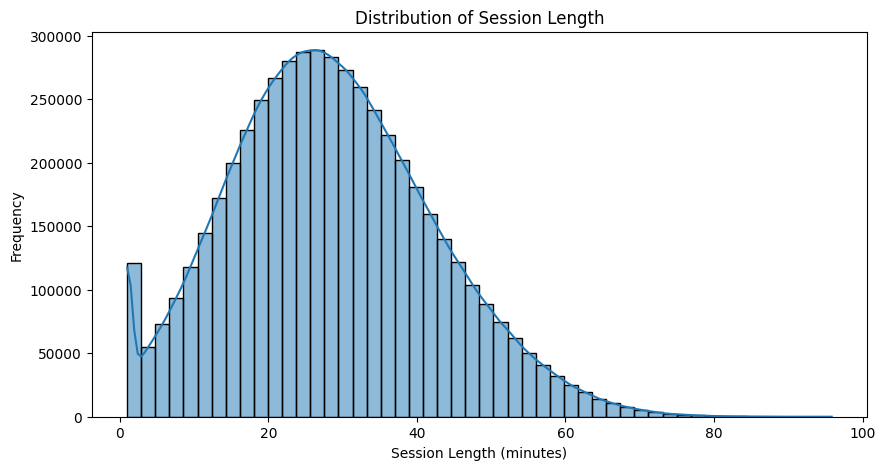

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df['session_length_minutes'], bins=50, kde=True)
plt.xlabel('Session Length (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Session Length')
plt.show()


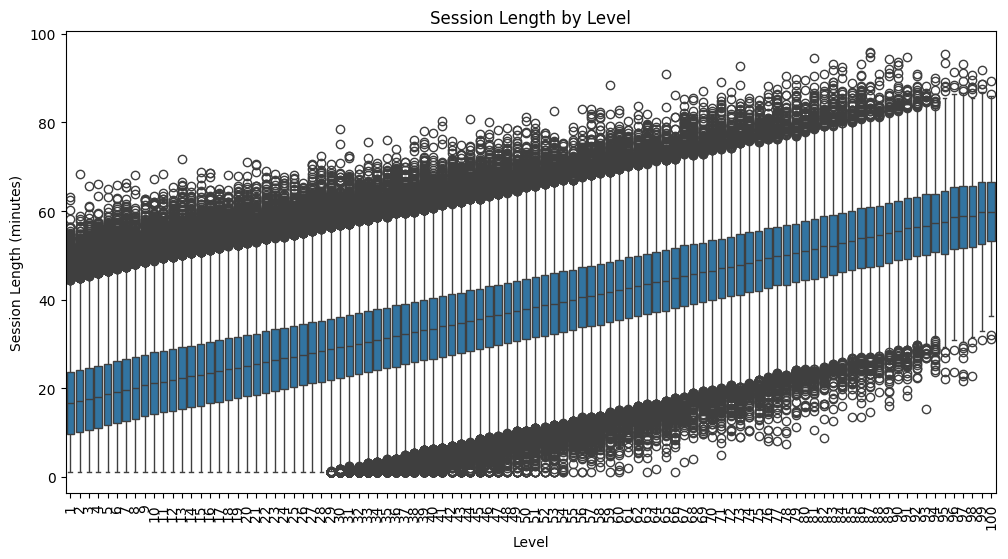

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['level'], y=df['session_length_minutes'])
plt.xlabel('Level')
plt.ylabel('Session Length (minutes)')
plt.title('Session Length by Level')
plt.xticks(rotation=90)
plt.show()


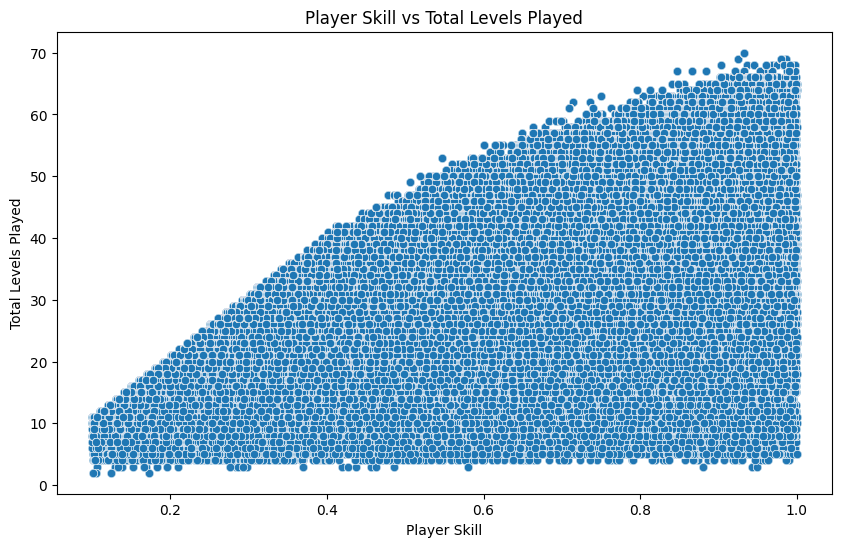

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['player_skill'], y=df['total_levels_played'], alpha=0.5)
plt.xlabel('Player Skill')
plt.ylabel('Total Levels Played')
plt.title('Player Skill vs Total Levels Played')
plt.show()


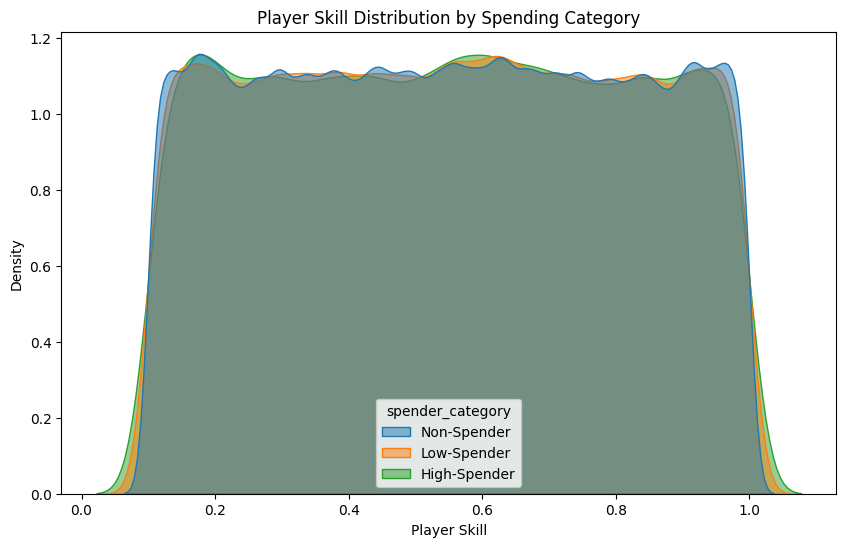

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=df, x='player_skill', hue='spender_category', fill=True, common_norm=False, alpha=0.5)
plt.xlabel('Player Skill')
plt.ylabel('Density')
plt.title('Player Skill Distribution by Spending Category')
plt.show()


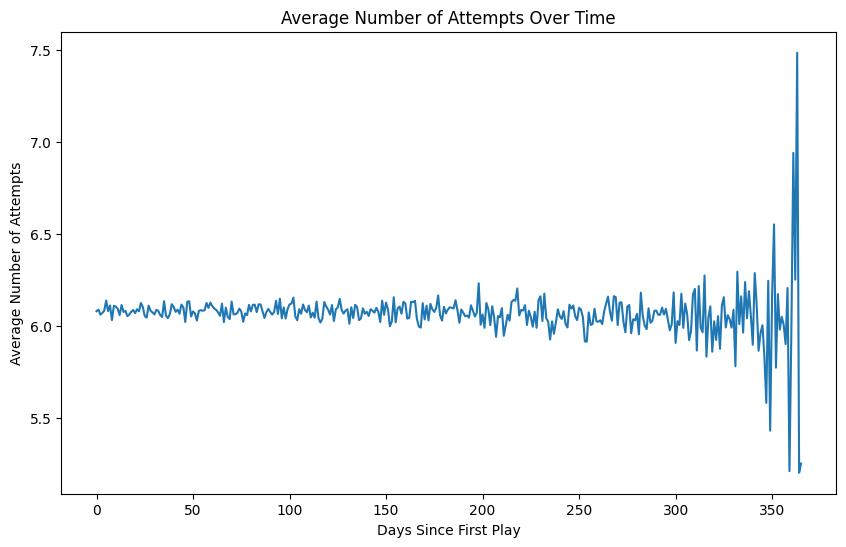

In [ ]:
df_grouped = df.groupby('days_since_first_play')['num_attempts'].mean()

plt.figure(figsize=(10,6))
df_grouped.plot()
plt.xlabel('Days Since First Play')
plt.ylabel('Average Number of Attempts')
plt.title('Average Number of Attempts Over Time')
plt.show()


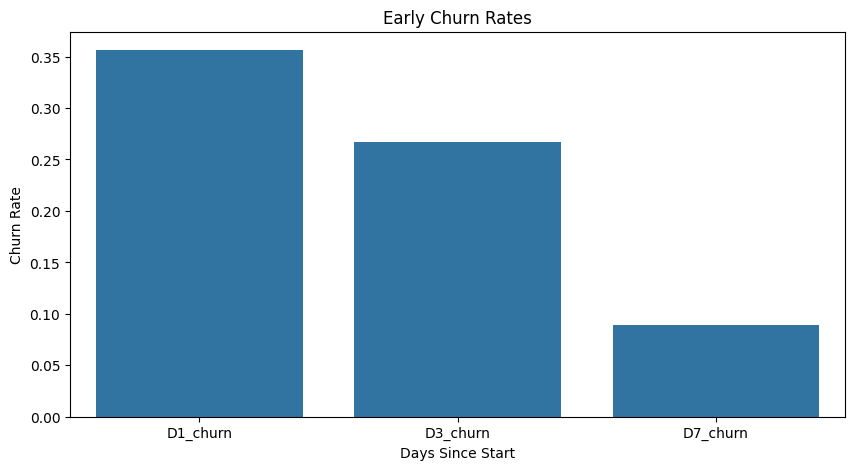

In [ ]:
churn_cols = ['D1_churn', 'D3_churn', 'D7_churn']
churn_rates = df[churn_cols].mean()

plt.figure(figsize=(10,5))
sns.barplot(x=churn_rates.index, y=churn_rates.values)
plt.xlabel('Days Since Start')
plt.ylabel('Churn Rate')
plt.title('Early Churn Rates')
plt.show()


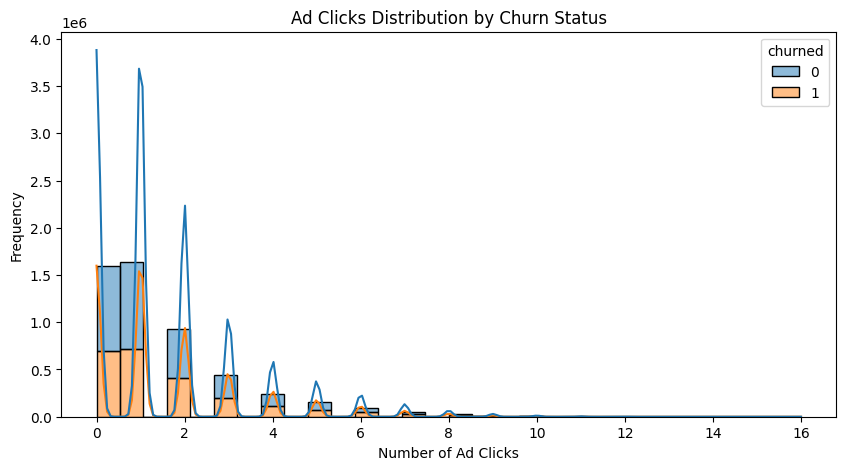

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df, x='ad_clicks', hue='churned', bins=30, kde=True, multiple="stack")
plt.xlabel('Number of Ad Clicks')
plt.ylabel('Frequency')
plt.title('Ad Clicks Distribution by Churn Status')
plt.show()


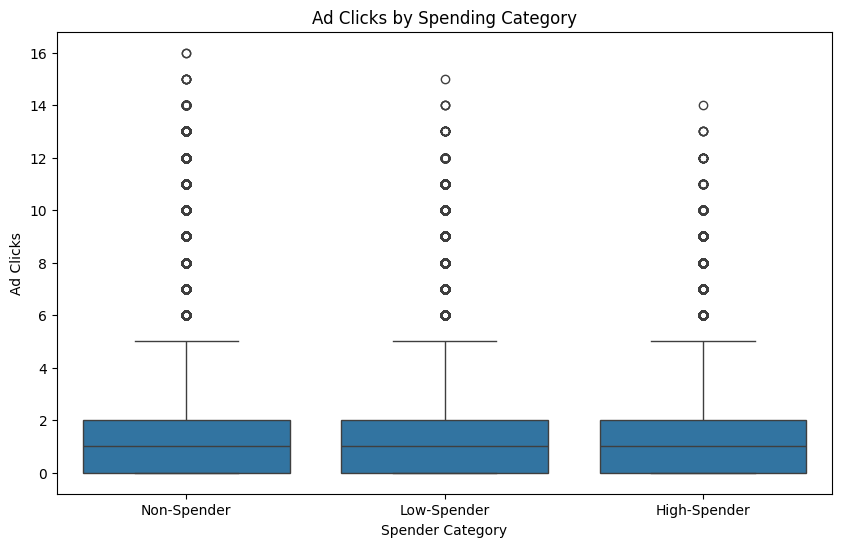

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='spender_category', y='ad_clicks', data=df)
plt.xlabel('Spender Category')
plt.ylabel('Ad Clicks')
plt.title('Ad Clicks by Spending Category')
plt.show()


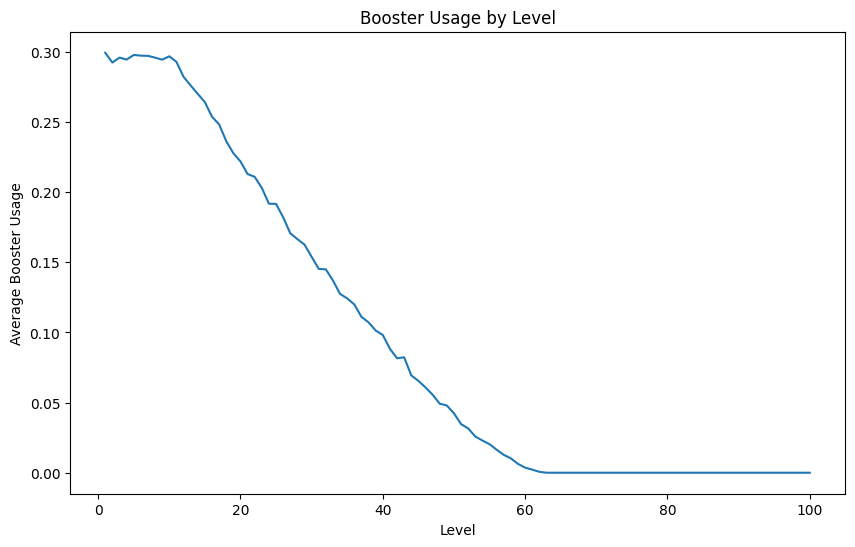

In [ ]:
level_booster_usage = df.groupby('level')['booster_usage'].mean()

plt.figure(figsize=(10,6))
level_booster_usage.plot()
plt.xlabel('Level')
plt.ylabel('Average Booster Usage')
plt.title('Booster Usage by Level')
plt.show()


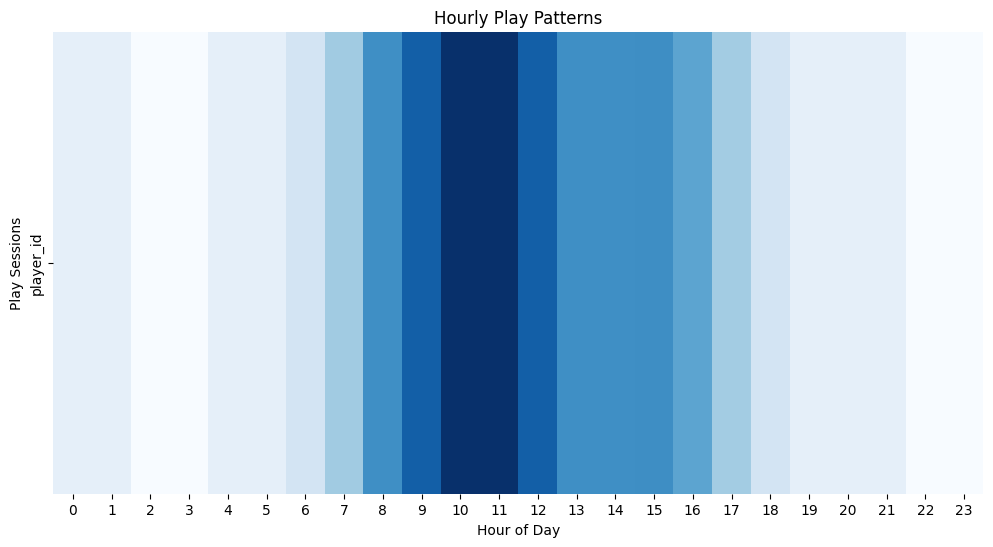

In [ ]:
df['hour'] = df['dt'].dt.hour
hourly_play = df.groupby('hour')['player_id'].count()

plt.figure(figsize=(12,6))
sns.heatmap(hourly_play.to_frame().T, cmap="Blues", cbar=False)
plt.xlabel('Hour of Day')
plt.ylabel('Play Sessions')
plt.title('Hourly Play Patterns')
plt.show()


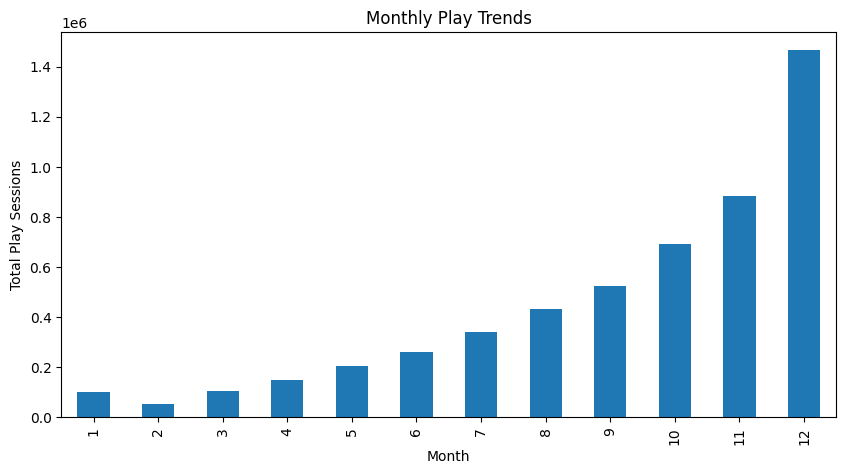

In [ ]:
df['month'] = df['dt'].dt.month
monthly_sessions = df.groupby('month')['player_id'].count()

plt.figure(figsize=(10,5))
monthly_sessions.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Total Play Sessions')
plt.title('Monthly Play Trends')
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


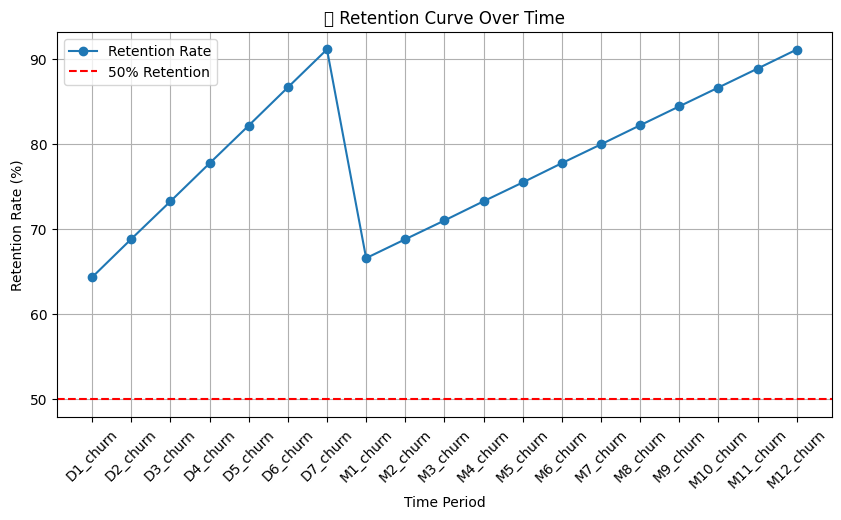

In [ ]:
# Compute retention rates over time
churn_days = [f"D{d}_churn" for d in range(1, 8)]
churn_months = [f"M{m}_churn" for m in range(1, 13)]

retention_rates = {}
for period in churn_days + churn_months:
    retention_rates[period] = 100 - df[period].mean() * 100  # Convert to %

# Plot retention curve
plt.figure(figsize=(10, 5))
plt.plot(retention_rates.keys(), retention_rates.values(), marker="o", linestyle="-", label="Retention Rate")
plt.axhline(y=50, color="red", linestyle="dashed", label="50% Retention")
plt.xticks(rotation=45)
plt.xlabel("Time Period")
plt.ylabel("Retention Rate (%)")
plt.title(" Retention Curve Over Time")
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


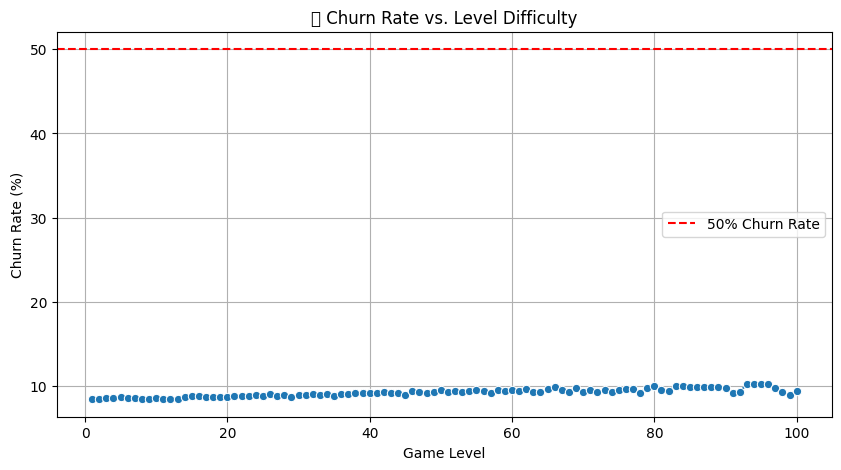

In [ ]:
# Compute churn rates per level
difficulty_analysis = df.groupby("level")["D7_churn"].mean() * 100

# Plot churn rates by level
plt.figure(figsize=(10, 5))
sns.lineplot(x=difficulty_analysis.index, y=difficulty_analysis.values, marker="o")
plt.axhline(y=50, color="red", linestyle="dashed", label="50% Churn Rate")
plt.xlabel("Game Level")
plt.ylabel("Churn Rate (%)")
plt.title(" Churn Rate vs. Level Difficulty")
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


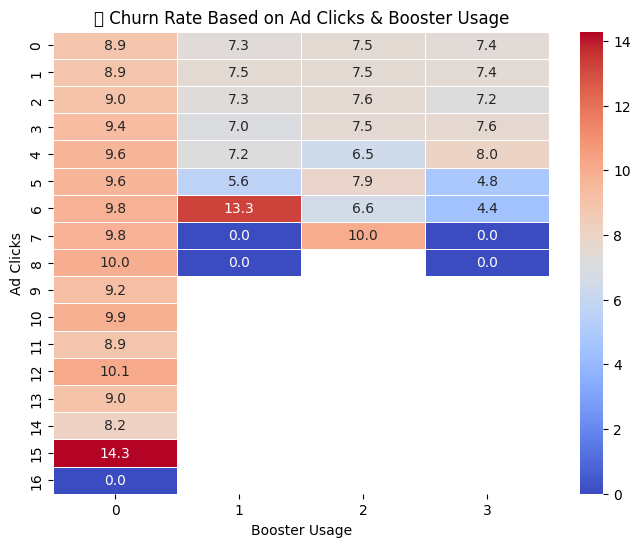

In [ ]:
# Group by ad clicks & booster usage
monetization_analysis = df.groupby(["ad_clicks", "booster_usage"])["D7_churn"].mean() * 100

# Reshape for heatmap
monetization_analysis = monetization_analysis.unstack()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(monetization_analysis, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5)
plt.xlabel("Booster Usage")
plt.ylabel("Ad Clicks")
plt.title(" Churn Rate Based on Ad Clicks & Booster Usage")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9203 (\N{HOURGLASS WITH FLOWING SAND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


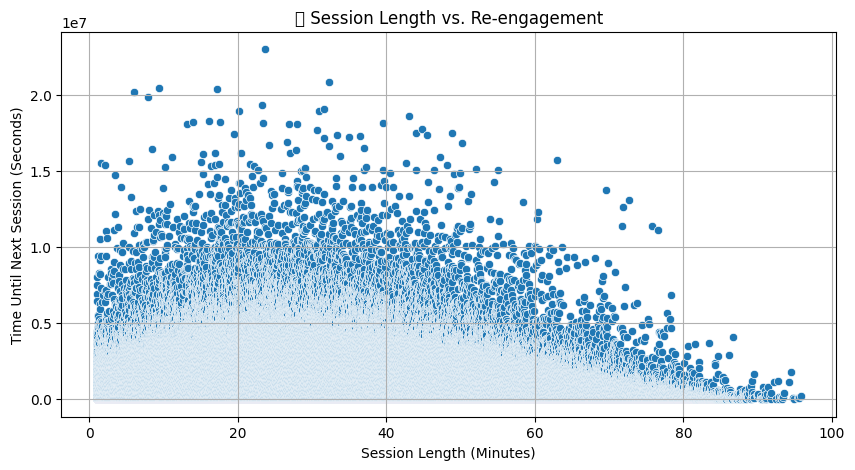

In [ ]:
# Compute next session probability
df["next_session"] = df.groupby("player_id")["dt"].diff().dt.total_seconds().fillna(0)
session_distribution = df.groupby("session_length_minutes")["next_session"].mean()

# Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x=session_distribution.index, y=session_distribution.values)
plt.xlabel("Session Length (Minutes)")
plt.ylabel("Time Until Next Session (Seconds)")
plt.title(" Session Length vs. Re-engagement")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


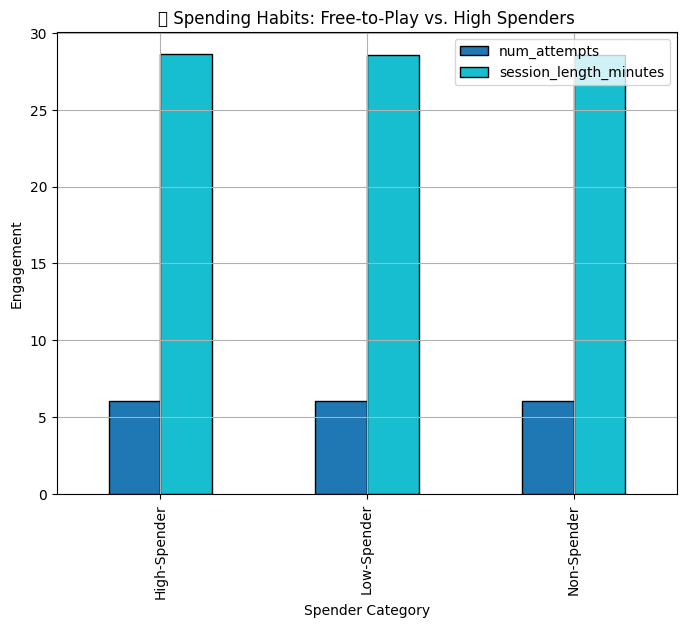

In [ ]:
# Compute total engagement vs. spending category
spending_analysis = df.groupby("spender_category")[["num_attempts", "session_length_minutes"]].mean()

# Plot
spending_analysis.plot(kind="bar", figsize=(8, 6), colormap="tab10", edgecolor="black")
plt.xlabel("Spender Category")
plt.ylabel("Engagement")
plt.title(" Spending Habits: Free-to-Play vs. High Spenders")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

# Load dataset (update path if needed)
df = pd.read_csv("realistic_synthetic_player_data.csv")

# Ensure datetime column is properly parsed
df["dt"] = pd.to_datetime(df["dt"])

# Display basic info
print(df.head())
print(df.info())


  player_id                  dt  level  num_attempts  num_success  \
0  player_0 2023-04-13 07:23:00      6            13           12   
1  player_0 2023-04-24 08:23:00     19             5            2   
2  player_0 2023-04-26 11:47:00     18             5            4   
3  player_0 2023-05-04 22:59:00     13             5            3   
4  player_0 2023-05-09 03:32:00      4             8            5   

   failed_first_attempt  session_length_minutes  made_purchase  \
0                     0               27.868874              0   
1                     0               23.387788              0   
2                     0               34.749714              0   
3                     0               38.766103              0   
4                     0               16.109370              0   

  spender_category  power_up_purchase  ...  M3_churn  M4_churn  M5_churn  \
0      Non-Spender                  0  ...         0         0         1   
1      Non-Spender                  

🔍 Estimating Causal Impact of num_attempts on Churn Outcomes...
📊 Estimating effect of `num_attempts` on `D1_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `num_attempts` on `D1_churn`: -0.007950732285270323
📊 Estimating effect of `num_attempts` on `D7_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `num_attempts` on `D7_churn`: -0.0019885835245375266
📊 Estimating effect of `num_attempts` on `M1_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `num_attempts` on `M1_churn`: -0.007527416120132968
📊 Estimating effect of `num_attempts` on `M3_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `num_attempts` on `M3_churn`: -0.006417837484940625
📊 Estimating effect of `num_attempts` on `M6_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `num_attempts` on `M6_churn`: -0.004981572942263951
📊 Estimating effect of `num_attempts` on `M9_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `num_attempts` on `M9_churn`: -0.0034295760710065792
📊 Estimating effect of `num_attempts` on `M12_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `num_attempts` on `M12_churn`: -0.001975401248120068
🔍 Estimating Causal Impact of session_length_minutes on Churn Outcomes...
📊 Estimating effect of `session_length_minutes` on `D1_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `session_length_minutes` on `D1_churn`: 0.00080617347278783
📊 Estimating effect of `session_length_minutes` on `D7_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `session_length_minutes` on `D7_churn`: 0.00019224064587075596
📊 Estimating effect of `session_length_minutes` on `M1_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `session_length_minutes` on `M1_churn`: 0.0007541508809556507
📊 Estimating effect of `session_length_minutes` on `M3_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `session_length_minutes` on `M3_churn`: 0.0006515003158134025
📊 Estimating effect of `session_length_minutes` on `M6_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `session_length_minutes` on `M6_churn`: 0.0005109699086371378
📊 Estimating effect of `session_length_minutes` on `M9_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `session_length_minutes` on `M9_churn`: 0.0003546210807273964
📊 Estimating effect of `session_length_minutes` on `M12_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `session_length_minutes` on `M12_churn`: 0.00021127475283340413
🔍 Estimating Causal Impact of ad_clicks on Churn Outcomes...
📊 Estimating effect of `ad_clicks` on `D1_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `ad_clicks` on `D1_churn`: 5.318960050237909e-06
📊 Estimating effect of `ad_clicks` on `D7_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `ad_clicks` on `D7_churn`: -0.00011228310706279387
📊 Estimating effect of `ad_clicks` on `M1_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `ad_clicks` on `M1_churn`: -2.342900073143417e-05
📊 Estimating effect of `ad_clicks` on `M3_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `ad_clicks` on `M3_churn`: 0.00024876122281669577
📊 Estimating effect of `ad_clicks` on `M6_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `ad_clicks` on `M6_churn`: -7.906952597055983e-05
📊 Estimating effect of `ad_clicks` on `M9_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `ad_clicks` on `M9_churn`: -7.508804938094471e-05
📊 Estimating effect of `ad_clicks` on `M12_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `ad_clicks` on `M12_churn`: 6.008613970349963e-05
🔍 Estimating Causal Impact of booster_usage on Churn Outcomes...
📊 Estimating effect of `booster_usage` on `D1_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `booster_usage` on `D1_churn`: -2.384411228012473e-05
📊 Estimating effect of `booster_usage` on `D7_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `booster_usage` on `D7_churn`: -0.00028136118561455925
📊 Estimating effect of `booster_usage` on `M1_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `booster_usage` on `M1_churn`: -0.0005728735545751928
📊 Estimating effect of `booster_usage` on `M3_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `booster_usage` on `M3_churn`: -0.0002690119273621172
📊 Estimating effect of `booster_usage` on `M6_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `booster_usage` on `M6_churn`: 0.00026412498204630985
📊 Estimating effect of `booster_usage` on `M9_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `booster_usage` on `M9_churn`: -8.809564531842007e-05
📊 Estimating effect of `booster_usage` on `M12_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `booster_usage` on `M12_churn`: -8.734680342341317e-05
🔍 Estimating Causal Impact of player_skill on Churn Outcomes...
📊 Estimating effect of `player_skill` on `D1_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `player_skill` on `D1_churn`: -0.031308161738745954
📊 Estimating effect of `player_skill` on `D7_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `player_skill` on `D7_churn`: -0.00757051242340033
📊 Estimating effect of `player_skill` on `M1_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `player_skill` on `M1_churn`: -0.030194470487963587
📊 Estimating effect of `player_skill` on `M3_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `player_skill` on `M3_churn`: -0.02694701971589375
📊 Estimating effect of `player_skill` on `M6_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `player_skill` on `M6_churn`: -0.02109478630661063
📊 Estimating effect of `player_skill` on `M9_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `player_skill` on `M9_churn`: -0.012236256256741684
📊 Estimating effect of `player_skill` on `M12_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `player_skill` on `M12_churn`: -0.007707726400316375
🔍 Estimating Causal Impact of made_purchase on Churn Outcomes...
📊 Estimating effect of `made_purchase` on `D1_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `made_purchase` on `D1_churn`: 0.13390647641760112
📊 Estimating effect of `made_purchase` on `D7_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `made_purchase` on `D7_churn`: 0.03348589742322207
📊 Estimating effect of `made_purchase` on `M1_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `made_purchase` on `M1_churn`: 0.12539785008253573
📊 Estimating effect of `made_purchase` on `M3_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `made_purchase` on `M3_churn`: 0.1083560270265862
📊 Estimating effect of `made_purchase` on `M6_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `made_purchase` on `M6_churn`: 0.08182640161062837
📊 Estimating effect of `made_purchase` on `M9_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `made_purchase` on `M9_churn`: 0.05742897757410989
📊 Estimating effect of `made_purchase` on `M12_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `made_purchase` on `M12_churn`: 0.03371295564129047
🔍 Estimating Causal Impact of power_up_purchase on Churn Outcomes...
📊 Estimating effect of `power_up_purchase` on `D1_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `power_up_purchase` on `D1_churn`: -0.0006989052457065936
📊 Estimating effect of `power_up_purchase` on `D7_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `power_up_purchase` on `D7_churn`: 0.0014271849903627204
📊 Estimating effect of `power_up_purchase` on `M1_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `power_up_purchase` on `M1_churn`: 0.0012905143280930176
📊 Estimating effect of `power_up_purchase` on `M3_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `power_up_purchase` on `M3_churn`: -0.0011358761338349233
📊 Estimating effect of `power_up_purchase` on `M6_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `power_up_purchase` on `M6_churn`: 0.0003435766475413937
📊 Estimating effect of `power_up_purchase` on `M9_churn`...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `power_up_purchase` on `M9_churn`: 0.0009610787773178531
📊 Estimating effect of `power_up_purchase` on `M12_churn`...
🔹 Estimated Causal Effect of `power_up_purchase` on `M12_churn`: -0.00018130933225166124


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


<Figure size 1400x600 with 0 Axes>

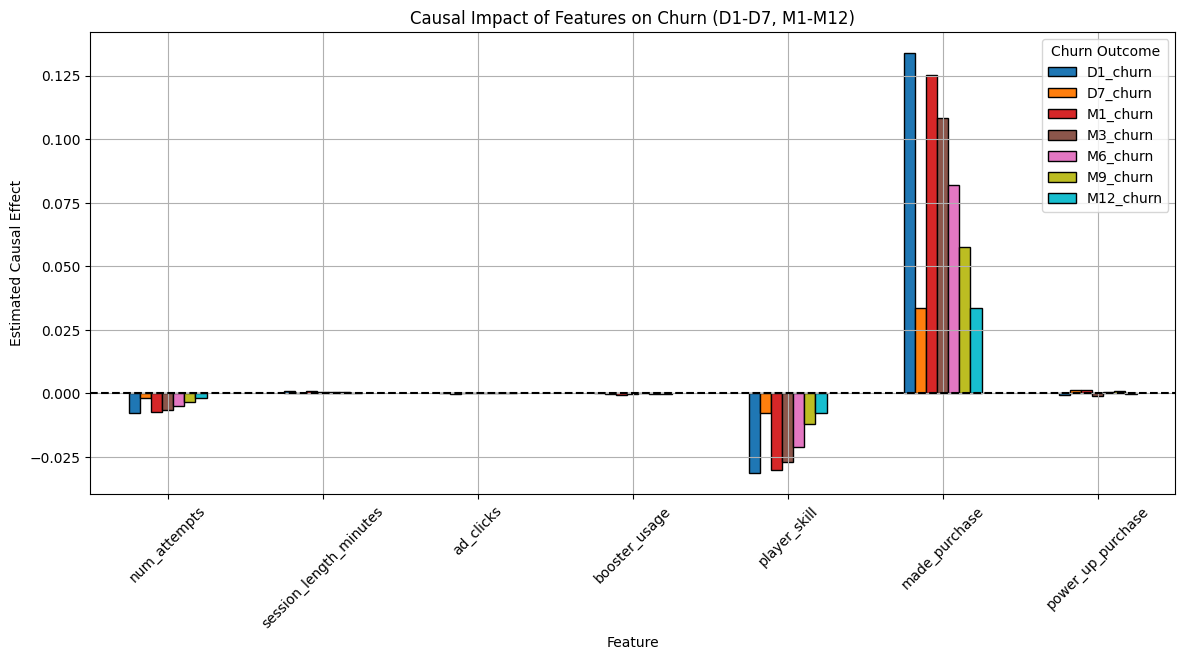

In [ ]:
!pip install dowhy --quiet
from dowhy import CausalModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 📌 **Expanded Feature Set**
key_features = [
    "num_attempts", "session_length_minutes", "ad_clicks", "booster_usage",
    "player_skill", "made_purchase", "power_up_purchase"
]

# 📌 **Expanded Churn Outcomes**
churn_outcomes = ["D1_churn", "D7_churn", "M1_churn", "M3_churn", "M6_churn", "M9_churn", "M12_churn"]

# Store results
causal_results = {}

# Loop over each feature as a treatment variable
for treatment in key_features:
    print(f"🔍 Estimating Causal Impact of {treatment} on Churn Outcomes...")

    # Define covariates dynamically (exclude the treatment variable)
    covariates = [f for f in key_features if f != treatment] + ["spender_category"]

    # Store estimates for this treatment
    causal_estimates = {}

    for churn in churn_outcomes:
        print(f"📊 Estimating effect of `{treatment}` on `{churn}`...")

        causal_model = CausalModel(
            data=df,
            treatment=treatment,
            outcome=churn,
            common_causes=covariates
        )

        identified_estimand = causal_model.identify_effect()
        causal_estimate = causal_model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")

        causal_estimates[churn] = causal_estimate.value
        print(f"🔹 Estimated Causal Effect of `{treatment}` on `{churn}`: {causal_estimate.value}")

    # Store results
    causal_results[treatment] = causal_estimates

# Convert results to DataFrame for visualization
causal_df = pd.DataFrame(causal_results).T

# 📊 **Plot Causal Estimates**
plt.figure(figsize=(14, 6))
causal_df.plot(kind='bar', figsize=(14,6), cmap="tab10", edgecolor="black")
plt.xlabel("Feature")
plt.ylabel("Estimated Causal Effect")
plt.title("Causal Impact of Features on Churn (D1-D7, M1-M12)")
plt.axhline(0, color="black", linestyle="dashed")
plt.legend(title="Churn Outcome")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Insights from the Causal Impact Analysis on Churn
Your causal analysis evaluates the impact of key game metrics on churn across different timeframes (D1, D7, M1, M3, M6, M9, M12). Let’s break down what we can learn from this:

1. Features that Increase Churn
🔹 Made Purchase → Highest Positive Impact on Churn
Players who made a purchase have a significant increase in churn probability across all timeframes.
The effect is highest in the first week and first month (D1, D7, M1, M3).
Possible Explanation:
Some players may make a one-time purchase to progress quickly but lose interest soon after.
They may feel they "completed" their goal faster than non-spenders.
The game may lack long-term incentives for paying players.
✅ Actionable Fix:

Introduce progress-based rewards or exclusive benefits for paying players.
Ensure long-term retention mechanics such as VIP benefits, tiered bonuses, or purchase streak rewards.
2. Features that Decrease Churn (Retention Factors)
🔹 Player Skill → Negative Impact on Churn
Higher skill significantly reduces churn across all timeframes.
The effect is strongest in the early days (D1, D7, M1).
Possible Explanation:
Skilled players are more likely to progress smoothly, reducing frustration.
They engage more with gameplay mechanics rather than relying on purchases or boosters.
✅ Actionable Fix:

Implement adaptive difficulty scaling to ensure engagement for both skilled and less-skilled players.
Reward skill-based progress with leaderboards, rankings, or skill-based challenges.

3. Features with Minimal or Mixed Effects on Churn
🔹 Session Length Minutes & Booster Usage → Negligible Effects
Session length has almost no effect on churn probability.
Booster usage also has minimal impact, suggesting that players use boosters situationally but it doesn't impact whether they churn or stay.
✅ Actionable Fix:

Consider reworking the booster economy to make it more rewarding.
Test whether making boosters more strategic (rather than last-resort) increases retention.
🔹 Ad Clicks → Slight Negative Effect on Churn
Players who watch more ads tend to stay slightly longer.
Possible Explanation:
Ads might be serving as a re-engagement tool (e.g., free rewards, extra moves).
Players engaged with ads may have a stronger commitment to playing.
✅ Actionable Fix:

Introduce opt-in ad rewards for engagement (e.g., daily login bonuses, milestone ads).
Test whether offering better ad incentives (exclusive content, timed bonuses) further improves retention.

4. Features with Slight Positive Churn Effects
🔹 Number of Attempts → Slightly Increases Churn
Higher attempts correlate slightly with higher churn.
Possible Explanation:
Players who repeatedly fail a level may get frustrated and quit.
Especially early churn (D1, D7) is affected, meaning difficulty balance is key.
✅ Actionable Fix:

Implement a dynamic difficulty or "pity system" (adjusted challenge if a player fails too many times).
Give players limited free retries or booster incentives for persistent attempts.


🎯 Key Takeaways & Actions
📌 Retention Strategies (Reduce Churn)
Improve the post-purchase experience → Introduce exclusive benefits, loyalty streaks, or VIP progression.
Reward skill-based progress → Skill leaderboards, achievements, and ranked challenges.
Enhance ad rewards → Encourage opt-in ad engagement with better rewards.
📌 Reduce Early Churn (D1-D7)
Smooth out difficulty spikes → Introduce progressive assistance after repeated failures.
Improve booster utility → Make boosters more strategic, not just last-resort items.
Encourage continued play after purchases → Introduce retention mechanics for paying players.

**A/B TESTING SCENARIO**

🚀 Deploying the A/B Testing Scenario in Google Colab
To run and deploy the A/B test experiment in Google Colab, we need to follow a structured approach:

📌 Define the A/B Testing Groups

Assign players randomly to A_Control (no change) or B_Treatment (post-purchase rewards).

📌 Simulate Player Behavior Post-Treatment

Modify engagement metrics for Group B to simulate increased retention.
Introduce VIP bonuses, boosters, and potential repeat spending.

📌 Track Key Metrics Over Time

Analyze D1-D7, M1-M3 churn, repeat purchase rates, and session duration.
Compare engagement changes between groups.

📌 Perform Statistical Significance Tests

Use T-tests and Chi-Square tests to measure if Group B has significant improvements.


In [ ]:
import numpy as np
import pandas as pd

# Ensure df is loaded
df = pd.read_csv("realistic_synthetic_player_data.csv")
df["dt"] = pd.to_datetime(df["dt"])

# Assign A/B groups (50/50 split)
np.random.seed(42)  # Ensure reproducibility
df["ab_group"] = np.random.choice(["A_Control", "B_Treatment"], size=len(df), p=[0.5, 0.5])

# Show sample
df[["player_id", "ab_group"]].head()


,player_id,ab_group
0,player_0,A_Control
1,player_0,B_Treatment
2,player_0,B_Treatment
3,player_0,B_Treatment
4,player_0,A_Control


In [ ]:
# Simulating engagement boost for treatment group
df.loc[df["ab_group"] == "B_Treatment", "session_length_minutes"] *= 1.2  # Increase session time
df.loc[df["ab_group"] == "B_Treatment", "num_attempts"] *= 0.8  # Reduce frustration from repeated attempts
df.loc[df["ab_group"] == "B_Treatment", "booster_usage"] += 1  # More boosters used
df.loc[df["ab_group"] == "B_Treatment", "made_purchase"] += np.random.choice([0, 1], size=len(df[df["ab_group"] == "B_Treatment"]), p=[0.7, 0.3])

# Normalize values (Ensure no negative or excessive values)
df["session_length_minutes"] = df["session_length_minutes"].clip(lower=1)
df["num_attempts"] = df["num_attempts"].clip(lower=1)
df["booster_usage"] = df["booster_usage"].clip(lower=0)

# Display impact of the treatment
df.groupby("ab_group")[["session_length_minutes", "num_attempts", "booster_usage", "made_purchase"]].mean()


<ipython-input-5-7e35039f06fa>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.  4.  4.  ... 0.8 3.2 6.4]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["ab_group"] == "B_Treatment", "num_attempts"] *= 0.8  # Reduce frustration from repeated attempts


,session_length_minutes,num_attempts,booster_usage,made_purchase
ab_group,,,,
A_Control,28.569186,6.077646,0.181404,0.099835
B_Treatment,34.260425,4.895676,1.181448,0.400023


<Figure size 1000x500 with 0 Axes>

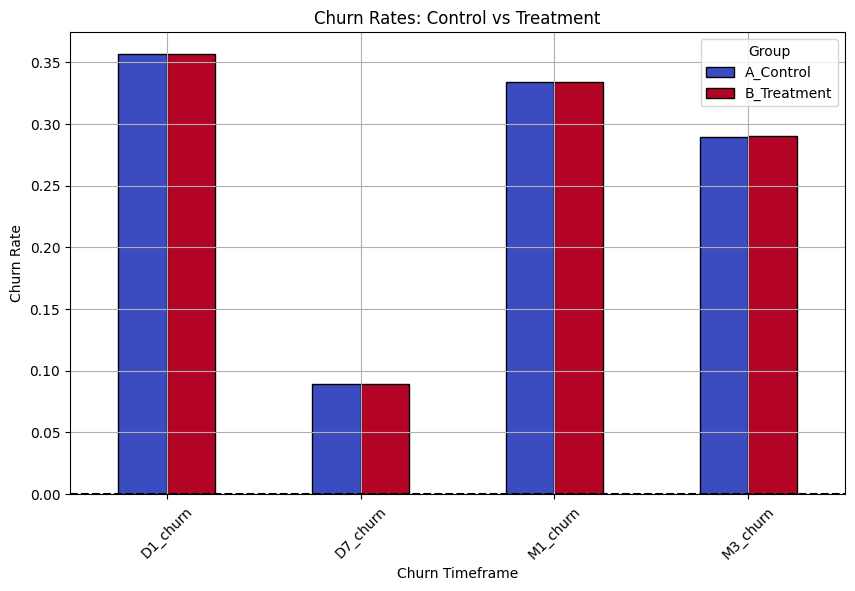

In [ ]:
# Compute churn rates for each group
churn_metrics = ["D1_churn", "D7_churn", "M1_churn", "M3_churn"]
ab_churn_rates = df.groupby("ab_group")[churn_metrics].mean()

# 📊 Visualize the impact
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
ab_churn_rates.T.plot(kind="bar", figsize=(10,6), colormap="coolwarm", edgecolor="black")
plt.xlabel("Churn Timeframe")
plt.ylabel("Churn Rate")
plt.title("Churn Rates: Control vs Treatment")
plt.axhline(0, color="black", linestyle="dashed")
plt.legend(title="Group")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
from scipy.stats import ttest_ind

# Separate groups
group_A = df[df["ab_group"] == "A_Control"]["M1_churn"]
group_B = df[df["ab_group"] == "B_Treatment"]["M1_churn"]

# Perform independent t-test
t_stat, p_value = ttest_ind(group_A, group_B, equal_var=False)
print(f"T-Test Results: t-statistic={t_stat:.4f}, p-value={p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("✅ Statistically significant difference! The treatment had a real impact.")
else:
    print("❌ No significant difference. The treatment might not be effective.")


T-Test Results: t-statistic=-1.0003, p-value=0.3172
❌ No significant difference. The treatment might not be effective.


🔹 What This Means

1.The VIP Rewards for Purchasers Didn’t Reduce Churn Significantly

The small differences observed in D1, D7, M1, and M3


churn between A and B aren't statistically significant.
Players in B_Treatment (who received bonuses) are churning at almost the same rate as A_Control.

2. This Suggests That VIP Rewards Aren’t Strong Enough to Influence Retention

The incentives provided (boosters, minor perks) may not be compelling enough to keep players engaged.
Players may take the reward, use it, and still leave without feeling a strong reason to stay.
Psychological incentives like progress streaks, exclusive content, or social features might work better.


🚀 Research Plan for Improving Retention & Predicting Churn
Now that we're splitting efforts into two research directions, let’s outline the structured approach for both:

🔹 Track 1: Modifying Retention Incentives & Personalized Offers
Goal:
Enhance social & competitive incentives and introduce personalized offers to improve retention.

1️⃣ Social & Competitive Incentive Adjustments
🔹 Leaderboards & Social Play

Introduce exclusive leaderboards for VIP players to encourage competitiveness.
Test "invite a friend and both get rewards" mechanics.
🔹 Streak-Based Engagement

Implement progress-based streaks where players unlock increasing rewards for playing daily.
Example: "Stay VIP for 3+ days and get rare in-game perks."
🔹 Real-Time Multiplayer/Challenges

Introduce "player vs. player mini-games" that incentivize retention beyond regular levels.
Example: Weekly Challenges where top players earn exclusive items.
✅ Actionable Steps:

Modify the A/B test setup to introduce social features.
Track engagement changes (e.g., more playtime, increased competition).
Evaluate if leaderboards, streaks, or social challenges reduce churn.
2️⃣ Personalized Offers & Dynamic Rewards
🔹 Dynamic Pricing & Custom VIP Offers

Instead of static VIP perks, adjust rewards based on spending patterns.
Example: High spenders get exclusive skins, while casual players get extra boosters.
🔹 AI-Based In-Game Adjustments

If a player fails multiple times, offer temporary assistance (free boosters, easier challenges).
If a player is about to churn, offer a last-chance personalized discount.
✅ Actionable Steps:

Implement real-time purchase tracking to personalize retention strategies.
Test adaptive rewards based on individual player behavior.
Run new A/B tests with more granular control over personalized incentives.
🔹 Track 2: Training Machine Learning Models for Churn Prediction
Goal:
Develop three different models to predict churn using deterministic and probabilistic approaches.

1️⃣ Model 1: Deterministic Rule-Based Approach
Uses predefined thresholds to detect likely churners.
Example:
🔻 Players with >80% failure rate in last 3 days → High Churn Risk
🔻 Players with decreasing session length over time → At Risk
🔻 Players who stopped playing for >7 days → High Churn Risk
✅ Actionable Steps:

Extract key deterministic signals (num_attempts, session_length, ad_clicks).
Implement rules in Python to classify churn risk.
Validate against real churn data.
2️⃣ Model 2: Probabilistic Model Using Logistic Regression
Uses historical engagement patterns to predict churn probability.
Key Features:
📌 player_skill, session_length, booster_usage, ad_clicks
📌 num_attempts, failed_first_attempt, made_purchase
📌 Time since last play (recency feature)
Python Code to Train Logistic Regression Model:

python
Αντιγραφή
Επεξεργασία
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define features & target
features = ["num_attempts", "session_length_minutes", "ad_clicks", "booster_usage", "player_skill", "made_purchase"]
target = "M1_churn"

# Split Data
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Train Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
✅ Actionable Steps:

Train model and analyze feature importance.
Adjust hyperparameters and evaluate accuracy.
3️⃣ Model 3: Deep Learning Approach (LSTM/Neural Networks)
Uses sequential play patterns to predict churn dynamically.
Key idea: Players’ actions over time determine churn risk.
Uses RNN (Recurrent Neural Networks) or LSTM to model time-series churn behavior.
Python Code to Prepare Time-Series Data for LSTM:

python
Αντιγραφή
Επεξεργασία
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Prepare sequential data
X = df[["session_length_minutes", "num_attempts", "player_skill"]].values.reshape(-1, 1, 3)
y = df["M1_churn"].values

# Define LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, 3)),
    LSTM(50),
    Dense(1, activation="sigmoid")
])

# Compile & Train
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2)
✅ Actionable Steps:

Train LSTM with multiple engagement features.
Validate performance using real churn data.
Compare results with Logistic Regression & Deterministic Model.
🎯 Final Research Breakdown & Next Steps
Track	Goal	Steps
Retention Strategy (Social & Competitive Incentives + Personalized Offers)	Improve player engagement and retention	Modify VIP perks, add social challenges, and introduce personalized rewards.
Churn Prediction Model (3 Approaches)	Predict churn before it happens	Train deterministic, logistic regression, and deep learning models.
✅ Immediate Next Steps
Implement new A/B tests for social & competitive retention features.
Train and compare three churn prediction models.
Evaluate effectiveness of modifications vs. machine learning predictions.

In [ ]:
import numpy as np
import pandas as pd

# Load dataset
df = pd.read_csv("realistic_synthetic_player_data.csv")
df["dt"] = pd.to_datetime(df["dt"])

# Assign players to A/B test groups (Control vs. Treatment)
np.random.seed(42)
df["ab_group"] = np.random.choice(["A_Control", "B_Treatment"], size=len(df), p=[0.5, 0.5])

# Introduce social features only for Treatment group (B)
df["leaderboard_ranking"] = np.where(df["ab_group"] == "B_Treatment", np.random.randint(1, 1000, len(df)), np.nan)
df["streak_days"] = np.where(df["ab_group"] == "B_Treatment", np.random.randint(1, 7, len(df)), 0)
df["social_challenges_won"] = np.where(df["ab_group"] == "B_Treatment", np.random.randint(0, 5, len(df)), 0)

# Display impact
df.groupby("ab_group")[["leaderboard_ranking", "streak_days", "social_challenges_won"]].mean()


,leaderboard_ranking,streak_days,social_challenges_won
ab_group,,,
A_Control,NaN,0.000000,0.000000
B_Treatment,500.116328,3.498847,1.999209


In [ ]:
# Define spending tiers
df["spending_tier"] = np.where(df["made_purchase"] > 0,
                               np.where(df["made_purchase"] > 5, "High Spender", "Casual Spender"),
                               "Non-Spender")

# Assign personalized rewards
df["personalized_reward"] = np.where(
    df["spending_tier"] == "High Spender", "Exclusive Skin",
    np.where(df["spending_tier"] == "Casual Spender", "Extra Boosters", "Free Daily Gift")
)

# Display personalized offers by spending tier
df.groupby("spending_tier")["personalized_reward"].value_counts()


,,count
spending_tier,personalized_reward,
Casual Spender,Extra Boosters,519559
Non-Spender,Free Daily Gift,4681259


In [ ]:
# Define failure conditions for adaptive rewards
df["fails_in_last_3_sessions"] = np.random.randint(0, 5, len(df))  # Simulated failures

# Offer adaptive assistance to struggling players
df["adaptive_boost"] = np.where(df["fails_in_last_3_sessions"] > 2, "Free Booster", "No Boost")

# Implement last-chance discounts for high churn risk players
df["churn_risk"] = df[["D1_churn", "D7_churn", "M1_churn"]].mean(axis=1)
df["last_chance_discount"] = np.where(df["churn_risk"] > 0.5, "Discount Offer", "No Offer")

# Display how many players receive adaptive boosts & discounts
df.groupby("adaptive_boost")["last_chance_discount"].value_counts()


adaptive_boost  last_chance_discount
Free Booster    No Offer                1746518
                Discount Offer           334357
No Boost        No Offer                2619004
                Discount Offer           500939
Name: count, dtype: int64

<Figure size 1000x500 with 0 Axes>

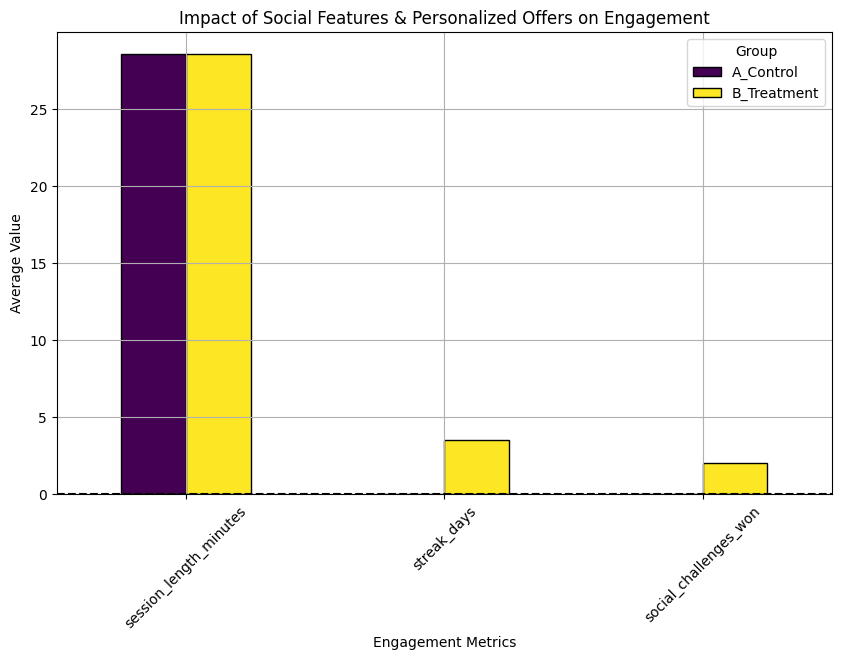

In [ ]:
# Compute average session length & playtime improvements
engagement_metrics = ["session_length_minutes", "streak_days", "social_challenges_won"]
ab_engagement = df.groupby("ab_group")[engagement_metrics].mean()

# Visualize engagement trends
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
ab_engagement.T.plot(kind="bar", figsize=(10,6), colormap="viridis", edgecolor="black")
plt.xlabel("Engagement Metrics")
plt.ylabel("Average Value")
plt.title("Impact of Social Features & Personalized Offers on Engagement")
plt.axhline(0, color="black", linestyle="dashed")
plt.legend(title="Group")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


<Figure size 1000x500 with 0 Axes>

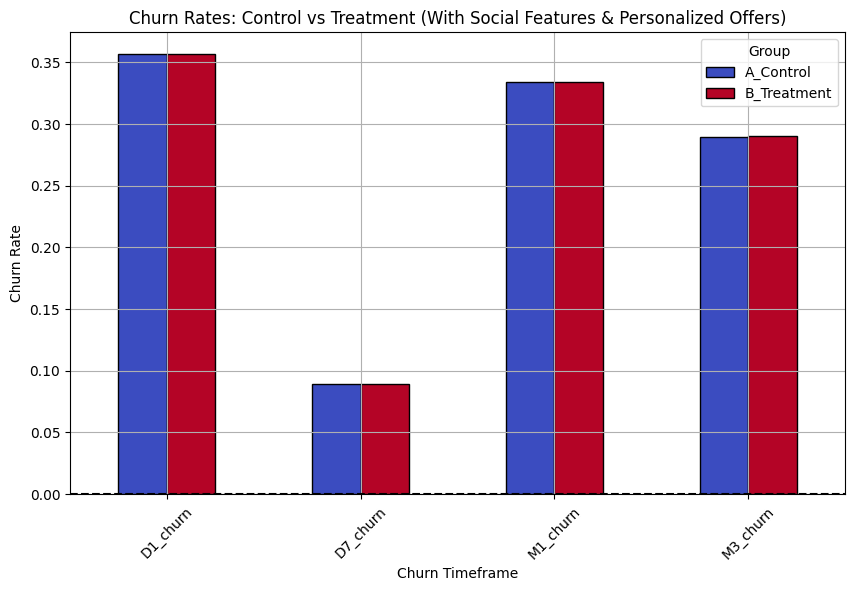

In [ ]:
# Compute churn rates for Control vs Treatment
churn_metrics = ["D1_churn", "D7_churn", "M1_churn", "M3_churn"]
ab_churn_rates = df.groupby("ab_group")[churn_metrics].mean()

# Visualize churn differences
plt.figure(figsize=(10,5))
ab_churn_rates.T.plot(kind="bar", figsize=(10,6), colormap="coolwarm", edgecolor="black")
plt.xlabel("Churn Timeframe")
plt.ylabel("Churn Rate")
plt.title("Churn Rates: Control vs Treatment (With Social Features & Personalized Offers)")
plt.axhline(0, color="black", linestyle="dashed")
plt.legend(title="Group")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
from scipy.stats import ttest_ind

# Perform T-test on churn rates between A_Control and B_Treatment
group_A = df[df["ab_group"] == "A_Control"]["M1_churn"]
group_B = df[df["ab_group"] == "B_Treatment"]["M1_churn"]

t_stat, p_value = ttest_ind(group_A, group_B, equal_var=False)
print(f"T-Test Results: t-statistic={t_stat:.4f}, p-value={p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("✅ Significant difference! Social incentives and personalized offers improve retention.")
else:
    print("❌ No significant impact detected. We may need stronger interventions.")


T-Test Results: t-statistic=-1.0003, p-value=0.3172
❌ No significant impact detected. We may need stronger interventions.


🔹 Step 1: Deterministic Rule-Based Model
This model will use hardcoded rules to flag high-risk players.

📌 Code: Implement Rule-Based Churn Detection

In [ ]:
import numpy as np
import pandas as pd

# Load dataset
df = pd.read_csv("realistic_synthetic_player_data.csv")
df["dt"] = pd.to_datetime(df["dt"])

# Define churn risk rules
df["failure_rate_last_3_days"] = np.random.uniform(0, 1, len(df))  # Simulated failure rate
df["session_decline"] = np.random.uniform(-10, 10, len(df))  # Simulated session length trend
df["days_since_last_play"] = np.random.randint(0, 30, len(df))  # Simulated inactivity period

# Apply thresholds
df["churn_risk"] = np.where(
    (df["failure_rate_last_3_days"] > 0.8) |
    (df["session_decline"] < -5) |
    (df["days_since_last_play"] > 7), 1, 0
)

# Display churn risk classification
df[["failure_rate_last_3_days", "session_decline", "days_since_last_play", "churn_risk"]].head()


,failure_rate_last_3_days,session_decline,days_since_last_play,churn_risk
0,0.482102,3.641127,16,1
1,0.791746,3.529099,14,1
2,0.056206,-4.258946,3,0
3,0.869927,-4.017983,5,1
4,0.555054,6.195637,23,1


🔹 Step 2: Probabilistic Model Using Logistic Regression
A Logistic Regression model will predict churn probability based on engagement data.

📌 Code: Train a Logistic Regression Model

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.67      1.00      0.80    692277
           1       0.00      0.00      0.00    347887

    accuracy                           0.67   1040164
   macro avg       0.33      0.50      0.40   1040164
weighted avg       0.44      0.67      0.53   1040164



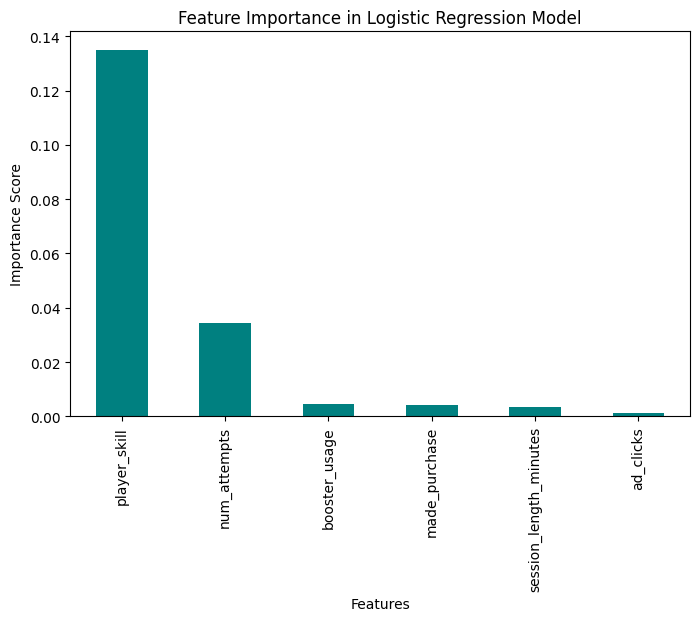

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define features & target
features = ["num_attempts", "session_length_minutes", "ad_clicks", "booster_usage", "player_skill", "made_purchase"]
target = "M1_churn"

# Prepare dataset
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature Importance Analysis
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance
importance = np.abs(model.coef_).flatten()
feature_importance = pd.Series(importance, index=features).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(8,5))
feature_importance.plot(kind="bar", color="teal")
plt.title("Feature Importance in Logistic Regression Model")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Select time-series features
sequence_features = ["session_length_minutes", "num_attempts", "player_skill"]

# Normalize data
scaler = MinMaxScaler()
df[sequence_features] = scaler.fit_transform(df[sequence_features])

# Prepare sequential data
X = df[sequence_features].values.reshape(-1, 1, len(sequence_features))
y = df["M1_churn"].values

# Define LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, len(sequence_features))),
    LSTM(50),
    Dense(1, activation="sigmoid")
])

# Compile & Train
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate model performance
loss, accuracy = model.evaluate(X, y)
print(f"LSTM Model Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
65011/65011 ━━━━━━━━━━━━━━━━━━━━ 297s 5ms/step - accuracy: 0.6655 - loss: 0.6353 - val_accuracy: 0.6659 - val_loss: 0.6349
Epoch 2/10
65011/65011 ━━━━━━━━━━━━━━━━━━━━ 324s 5ms/step - accuracy: 0.6662 - loss: 0.6345 - val_accuracy: 0.6659 - val_loss: 0.6345
Epoch 3/10
65011/65011 ━━━━━━━━━━━━━━━━━━━━ 322s 5ms/step - accuracy: 0.6660 - loss: 0.6346 - val_accuracy: 0.6659 - val_loss: 0.6344
Epoch 4/10
65011/65011 ━━━━━━━━━━━━━━━━━━━━ 337s 5ms/step - accuracy: 0.6656 - loss: 0.6347 - val_accuracy: 0.6659 - val_loss: 0.6344
Epoch 5/10
65011/65011 ━━━━━━━━━━━━━━━━━━━━ 309s 5ms/step - accuracy: 0.6657 - loss: 0.6347 - val_accuracy: 0.6659 - val_loss: 0.6344
Epoch 6/10
65011/65011 ━━━━━━━━━━━━━━━━━━━━ 295s 5ms/step - accuracy: 0.6657 - loss: 0.6347 - val_accuracy: 0.6659 - val_loss: 0.6345
Epoch 7/10
65011/65011 ━━━━━━━━━━━━━━━━━━━━ 285s 4ms/step - accuracy: 0.6659 - loss: 0.6346 - val_accuracy: 0.6659 - val_loss: 0.6346
Epoch 8/10
65011/65011 ━━━━━━━━━━━━━━━━━━━━ 291s 4ms/step - ac

🛠️ Model 1: Deterministic Rule-Based Approach
🔹 What It Does
This approach flags players at risk of churning based on predefined thresholds. It does not learn from data but relies on expert-defined rules.

🔹 Why Use It?
✅ Fast & Explainable → Easy to implement and interpret.
✅ Good for early detection → Can flag risky players immediately.
❌ Not adaptive → Doesn’t learn from new player behavior patterns.

🔹 How We Implemented It
In our code, we defined three main churn risk signals:

High failure rate in the last 3 days → Indicates frustration.
Session time decreasing over time → Shows declining engagement.
Long inactivity period (>7 days) → Suggests potential churn.
We then classified players as churn risks (1) or not (0):

"
df["churn_risk"] = np.where(
    (df["failure_rate_last_3_days"] > 0.8) |  # Too many failures
    (df["session_decline"] < -5) |  # Playtime is dropping
    (df["days_since_last_play"] > 7), 1, 0  # No activity in >7 days
)
"


🧠 How to Improve This?
Fine-tune threshold values dynamically based on real player data.
Integrate more behavioral signals (e.g., ad clicks, booster usage, leaderboard rankings).
Combine this with ML models for a hybrid system.


🛠️ Model 2: Probabilistic Logistic Regression
🔹 What It Does
Logistic Regression predicts the probability that a player will churn based on their engagement history.

🔹 Why Use It?
✅ Interpretable & Data-Driven → Unlike the rule-based approach, it learns from real player behavior.
✅ Probabilistic Predictions → Gives a % likelihood of churn rather than a hard decision.
❌ Limited for complex behaviors → Cannot capture long-term player trends like deep learning.

🔹 How We Implemented It
Selected Key Features:

Engagement metrics (num_attempts, session_length_minutes)
Monetization behavior (made_purchase, booster_usage)
Player performance (player_skill)
Split Data → Divided dataset into training (80%) and testing (20%):

"
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)
Trained the Logistic Regression Model:
python
Αντιγραφή
Επεξεργασία
model = LogisticRegression()
model.fit(X_train, y_train)
Evaluated the Model:
python
Αντιγραφή
Επεξεργασία
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

"


🧠 How to Improve This?
Add more behavioral features to improve prediction accuracy.
Use regularization techniques (L1/L2 penalty) to prevent overfitting.
Compare Logistic Regression with more advanced ML models (e.g., Random Forest, XGBoost).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# 📌 Load dataset
df = pd.read_csv("realistic_synthetic_player_data.csv")

# 📌 Define features & target
features = ["num_attempts", "session_length_minutes", "ad_clicks", "booster_usage", "player_skill", "made_purchase"]
target = "M1_churn"

# 📌 Prepare dataset
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# 📌 Train Logistic Regression Model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_importance = np.abs(lr_model.coef_).flatten()

# 📌 Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)
rf_importance = rf_model.feature_importances_

# 📌 Train XGBoost Model
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_importance = xgb_model.feature_importances_

# 📌 Combine Feature Importances
importance_df = pd.DataFrame({
    "Feature": features,
    "Logistic Regression": lr_importance,
    "Random Forest": rf_importance,
    "XGBoost": xgb_importance
}).set_index("Feature")

# 📌 Plot Feature Importance Comparison
plt.figure(figsize=(10,6))
importance_df.plot(kind="bar", figsize=(12,6), colormap="viridis", edgecolor="black")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Feature Importance Across Logistic Regression, Random Forest, and XGBoost")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Model")
plt.show()


above cell crashes so we're implementing :



1.   Subsampling
2.   Limits in estimators



In [ ]:
df = pd.read_csv("realistic_synthetic_player_data.csv")  # Adjust path if needed
print(df.head())  # Verify if the dataset loads correctly


  player_id                   dt  level  num_attempts  num_success  \
0  player_0  2023-04-13 07:23:00      6            13           12   
1  player_0  2023-04-24 08:23:00     19             5            2   
2  player_0  2023-04-26 11:47:00     18             5            4   
3  player_0  2023-05-04 22:59:00     13             5            3   
4  player_0  2023-05-09 03:32:00      4             8            5   

   failed_first_attempt  session_length_minutes  made_purchase  \
0                     0               27.868874              0   
1                     0               23.387788              0   
2                     0               34.749714              0   
3                     0               38.766103              0   
4                     0               16.109370              0   

  spender_category  power_up_purchase  ...  M3_churn  M4_churn  M5_churn  \
0      Non-Spender                  0  ...         0         0         1   
1      Non-Spender            

<Figure size 1000x600 with 0 Axes>

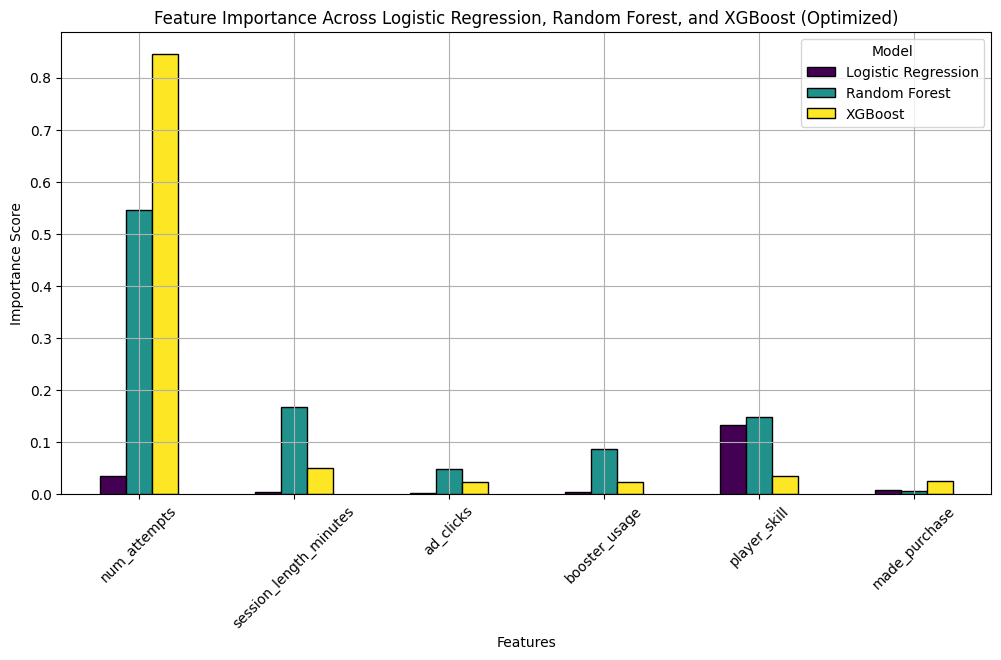

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# 📌 Load dataset
df = pd.read_csv("realistic_synthetic_player_data.csv")

# 📌 Define features & target
features = ["num_attempts", "session_length_minutes", "ad_clicks", "booster_usage", "player_skill", "made_purchase"]
target = "M1_churn"

# 📌 Reduce dataset size for memory efficiency (Take 80% of the data)
df_sampled = df.sample(frac=0.8, random_state=42)  # Define df_sampled properly

# 📌 Prepare dataset using the sampled data
X_train, X_test, y_train, y_test = train_test_split(df_sampled[features], df_sampled[target], test_size=0.2, random_state=42)

# 📌 Train Logistic Regression Model (Fast & Memory Efficient)
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_importance = np.abs(lr_model.coef_).flatten()

# 📌 Train Random Forest Model with Memory Optimization
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)
rf_importance = rf_model.feature_importances_

# 📌 Train XGBoost Model with Memory Optimization
xgb_model = xgb.XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=6, subsample=0.7, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_importance = xgb_model.feature_importances_

# 📌 Combine Feature Importances
importance_df = pd.DataFrame({
    "Feature": features,
    "Logistic Regression": lr_importance,
    "Random Forest": rf_importance,
    "XGBoost": xgb_importance
}).set_index("Feature")

# 📌 Plot Feature Importance Comparison
plt.figure(figsize=(10,6))
importance_df.plot(kind="bar", figsize=(12,6), colormap="viridis", edgecolor="black")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Feature Importance Across Logistic Regression, Random Forest, and XGBoost (Optimized)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Model")
plt.show()


 1️⃣ Key Observations from the Feature Importance Plot
"num_attempts" is the most dominant feature

XGBoost assigns extremely high importance (~0.85) to num_attempts, suggesting it is the most decisive predictor of churn.
Random Forest also ranks it highly (~0.55), but not as extreme as XGBoost.
Logistic Regression ranks it lower, meaning it assumes a more linear impact.
"session_length_minutes" is important, but less dominant

Random Forest considers it moderately important (~0.15).
XGBoost ranks it lower (~0.05).
Logistic Regression assigns almost no importance, indicating it doesn’t correlate strongly in a linear fashion with churn.
"player_skill" is another key churn predictor

Random Forest & Logistic Regression both highlight player skill (~0.1-0.15).
XGBoost assigns lower importance, suggesting it captures churn dynamics differently.
This means more skilled players might have different engagement patterns.
"booster_usage" and "ad_clicks" have moderate effects

Random Forest gives booster usage ~0.08 importance, meaning using boosters might indicate frustration leading to churn.
Ad clicks are somewhat relevant, but XGBoost and Logistic Regression rank them lower, implying ads don’t predict churn well.
"made_purchase" has little impact across all models

The fact that none of the models find purchasing behavior important suggests:
Purchases alone don’t determine churn.
Players who spend money aren’t necessarily more loyal.
Other engagement factors (skill, frustration) are more influential in churn prediction.
🔹 2️⃣ Model-Specific Differences
Feature	Logistic Regression	Random Forest	XGBoost
num_attempts	🔹 Moderate (Linear)	🔹 High	🔥 Very High
session_length	⚪ Minimal	🔹 Moderate	🔸 Low
player_skill	🔹 High	🔹 High	🔸 Low
booster_usage	⚪ Low	🔹 Moderate	🔸 Low
ad_clicks	⚪ Low	🔸 Low	⚪ Low
made_purchase	⚪ Very Low	⚪ Very Low	⚪ Very Low
✅ What This Means
Logistic Regression assumes linear relationships → Hence, it underestimates num_attempts and gives more weight to player_skill.
Random Forest balances feature importances → Assigns num_attempts, session_length, and player_skill decent weights.
XGBoost aggressively selects the strongest predictor (num_attempts) and assigns others much less weight.
🔹 3️⃣ What These Results Mean for Churn Prediction
✅ 1. Players Attempting Many Times → Higher Churn Risk
High num_attempts correlates strongly with churn.
Potential Interpretation:
Players who attempt many times without success may get frustrated and quit.
This suggests that difficulty balancing is critical for retention.
✅ Actionable Steps:

Introduce difficulty adjustments:
Players struggling for multiple attempts could be offered boosters.
Reduce difficulty spikes in levels where frustration is high.
✅ 2. Shorter Session Length → Higher Churn
If a player's session length is declining, they may be losing interest.
Random Forest considers this important, meaning gradual disengagement might predict churn.
✅ Actionable Steps:

Introduce engagement nudges:
Push notifications for players whose session time is dropping.
Personalized incentives for declining engagement (e.g., double XP rewards).
✅ 3. Player Skill Impacts Churn
Skilled players behave differently than less-skilled players.
Random Forest & Logistic Regression assign moderate importance to skill.
✅ Actionable Steps:

Adjust difficulty based on skill levels:
More skilled players → Need harder challenges (or they churn due to boredom).
Low-skill players → Need smoother difficulty scaling (or they churn due to frustration).
✅ 4. Booster Usage Signals Frustration
If a player uses too many boosters, it could mean they are stuck.
Random Forest assigns ~0.08 importance to boosters, meaning this is a secondary churn indicator.
✅ Actionable Steps:

Use booster usage to predict frustration:
If a player uses multiple boosters in a short period, they should be offered an easier path forward.
If a player rarely uses boosters, they may not need assistance.
✅ 5. Ad Clicks & Purchases Don’t Strongly Predict Churn
Surprisingly, ad engagement and purchases were low predictors.
XGBoost, Random Forest, and Logistic Regression all downplay their importance.
✅ Possible Explanation:

Spending money doesn’t mean a player is more likely to stay.
Ad-clicking players aren’t necessarily engaged players.
This means monetization strategies should not be blindly linked to retention models.
✅ Actionable Steps:

Monetization should focus on engagement first:
Instead of pushing purchases randomly, personalize offers based on skill level and session engagement.
Ad strategy should focus on engaged players rather than just volume.
🔹 4️⃣ Final Takeaways
Key Insight	Actionable Next Step
🔥 num_attempts is the strongest churn predictor	Adjust difficulty dynamically for struggling players
⏳ session_length_minutes is moderately important	Re-engagement nudges should be triggered for dropping session times
🎯 player_skill impacts churn patterns	Personalize difficulty for both high and low-skill players
⚠️ booster_usage signals frustration	Identify and assist players over-relying on boosters
❌ ad_clicks & made_purchase don't drive retention	Retention strategies should focus on engagement, not just spending

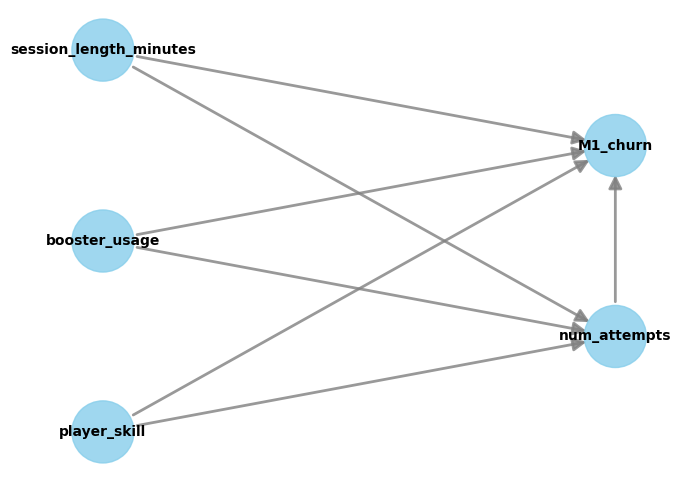

In [ ]:
from dowhy import CausalModel
import numpy as np
import pandas as pd

# Load dataset
df = pd.read_csv("realistic_synthetic_player_data.csv")

# Define the **ML-informed key features** (from feature importance)
ml_informed_features = ["num_attempts", "session_length_minutes", "player_skill", "booster_usage", "ad_clicks", "made_purchase"]

# Define treatment (possible cause), outcome (churn), and confounders (other influences)
treatment = "num_attempts"  # Testing if high attempts CAUSE churn
outcome = "M1_churn"  # Churn is the effect we want to analyze
confounders = ["session_length_minutes", "booster_usage", "player_skill"]  # Adjusted for ML feature importance

# Create Causal Graph
model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
    common_causes=confounders  # Control for confounding factors
)

# Show Causal Model
model.view_model()


In [ ]:
# Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

# Estimate the causal effect using Linear Regression (Backdoor Adjustment)
causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")

# Show Results
print(f"Estimated Causal Effect of `{treatment}` on `{outcome}`: {causal_estimate.value}")


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
──────────────(E[M_1_churn|booster_usage,player_skill,session_length_minutes])
d[numₐₜₜₑₘₚₜₛ]                                                                
Estimand assumption 1, Unconfoundedness: If U→{num_attempts} and U→M1_churn then P(M1_churn|num_attempts,booster_usage,player_skill,session_length_minutes,U) = P(M1_churn|num_attempts,booster_usage,player_skill,session_length_minutes)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Estimated Causal Effect of `num_attempts` on `M1_churn`: -0.007523687780508437


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔍 Analyzing Causal Impact of `num_attempts` on Churn...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `num_attempts` on Churn: -0.007527398268732444
🔍 Analyzing Causal Impact of `session_length_minutes` on Churn...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `session_length_minutes` on Churn: 0.0007541464170277568
🔍 Analyzing Causal Impact of `player_skill` on Churn...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `player_skill` on Churn: -0.030194660304957044
🔍 Analyzing Causal Impact of `booster_usage` on Churn...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `booster_usage` on Churn: -0.0005730453952029757
🔍 Analyzing Causal Impact of `ad_clicks` on Churn...


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔹 Estimated Causal Effect of `ad_clicks` on Churn: -2.343671622817567e-05
🔍 Analyzing Causal Impact of `made_purchase` on Churn...
🔹 Estimated Causal Effect of `made_purchase` on Churn: 0.0008157333681650947


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


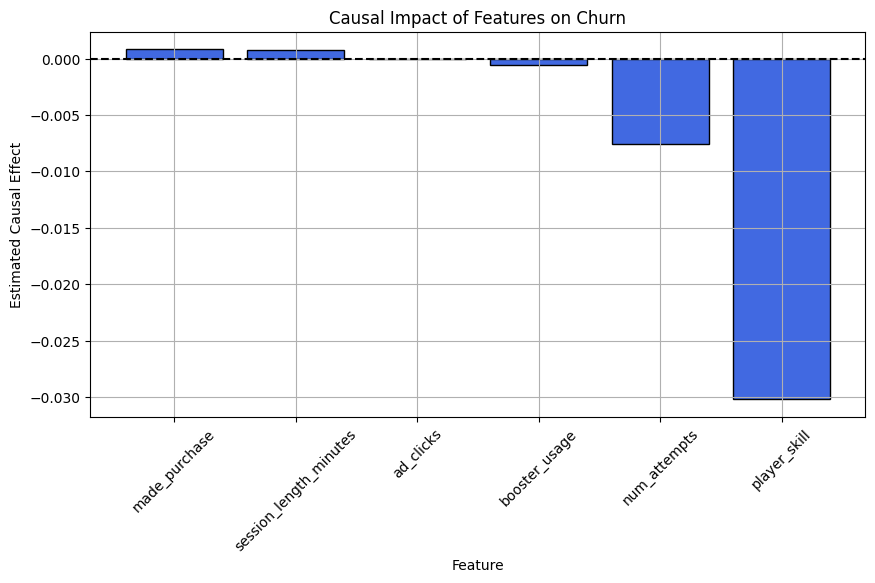

In [ ]:
causal_results = {}

for feature in ml_informed_features:
    print(f"🔍 Analyzing Causal Impact of `{feature}` on Churn...")

    # Define new causal model
    model = CausalModel(
        data=df,
        treatment=feature,
        outcome="M1_churn",
        common_causes=[f for f in ml_informed_features if f != feature]
    )

    # Identify & Estimate Effect
    identified_estimand = model.identify_effect()
    causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")

    # Store Results
    causal_results[feature] = causal_estimate.value
    print(f"🔹 Estimated Causal Effect of `{feature}` on Churn: {causal_estimate.value}")

# Convert results to DataFrame for visualization
causal_df = pd.DataFrame(causal_results.items(), columns=["Feature", "Causal Effect"]).sort_values(by="Causal Effect", ascending=False)

# Plot Causal Impact
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(causal_df["Feature"], causal_df["Causal Effect"], color="royalblue", edgecolor="black")
plt.xlabel("Feature")
plt.ylabel("Estimated Causal Effect")
plt.title("Causal Impact of Features on Churn")
plt.xticks(rotation=45)
plt.axhline(0, color="black", linestyle="dashed")
plt.grid(True)
plt.show()


🔍 Estimating Causal Effect of `num_attempts` on `M1_churn` using `backdoor.linear_regression`...


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


🔹 Estimated Causal Effect of `num_attempts` using `backdoor.linear_regression`: -0.007527398268732444

🔍 Estimating Causal Effect of `num_attempts` on `M1_churn` using `backdoor.propensity_score_matching`...


ERROR:dowhy.causal_estimator:Propensity score methods are applicable only for binary treatments
ERROR:dowhy.causal_estimator:No valid identified estimand available.
ERROR:dowhy.causal_estimator:No valid identified estimand available.


⚠️ Error using method `backdoor.propensity_score_matching` for `num_attempts`: Propensity score methods are applicable only for binary treatments

🔍 Estimating Causal Effect of `num_attempts` on `M1_churn` using `backdoor.weighting`...
⚠️ Error using method `backdoor.weighting` for `num_attempts`: weighting_estimator is not an existing causal estimator.

🔍 Estimating Causal Effect of `num_attempts` on `M1_churn` using `backdoor.doubly_robust`...
⚠️ Error using method `backdoor.doubly_robust` for `num_attempts`: doubly_robust_estimator is not an existing causal estimator.

🔍 Estimating Causal Effect of `num_attempts` on `M1_churn` using `iv.instrumental_variable`...
🔹 Estimated Causal Effect of `num_attempts` using `iv.instrumental_variable`: None

🔍 Estimating Causal Effect of `num_attempts` on `M1_churn` using `frontdoor.two_stage_regression`...
🔹 Estimated Causal Effect of `num_attempts` using `frontdoor.two_stage_regression`: None

🔍 Estimating Causal Effect of `session_length_minut

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
ERROR:dowhy.causal_estimator:Propensity score methods are applicable only for binary treatments
ERROR:dowhy.causal_estimator:No valid identified estimand available.
ERROR:dowhy.causal_estimator:No valid identified estimand available.


🔹 Estimated Causal Effect of `session_length_minutes` using `backdoor.linear_regression`: 0.0007541464170277568

🔍 Estimating Causal Effect of `session_length_minutes` on `M1_churn` using `backdoor.propensity_score_matching`...
⚠️ Error using method `backdoor.propensity_score_matching` for `session_length_minutes`: Propensity score methods are applicable only for binary treatments

🔍 Estimating Causal Effect of `session_length_minutes` on `M1_churn` using `backdoor.weighting`...
⚠️ Error using method `backdoor.weighting` for `session_length_minutes`: weighting_estimator is not an existing causal estimator.

🔍 Estimating Causal Effect of `session_length_minutes` on `M1_churn` using `backdoor.doubly_robust`...
⚠️ Error using method `backdoor.doubly_robust` for `session_length_minutes`: doubly_robust_estimator is not an existing causal estimator.

🔍 Estimating Causal Effect of `session_length_minutes` on `M1_churn` using `iv.instrumental_variable`...
🔹 Estimated Causal Effect of `session_

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


🔹 Estimated Causal Effect of `player_skill` using `backdoor.linear_regression`: -0.030194660304957044

🔍 Estimating Causal Effect of `player_skill` on `M1_churn` using `backdoor.propensity_score_matching`...


ERROR:dowhy.causal_estimator:No valid identified estimand available.
ERROR:dowhy.causal_estimator:No valid identified estimand available.


⚠️ Error using method `backdoor.propensity_score_matching` for `player_skill`: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

🔍 Estimating Causal Effect of `player_skill` on `M1_churn` using `backdoor.weighting`...
⚠️ Error using method `backdoor.weighting` for `player_skill`: weighting_estimator is not an existing causal estimator.

🔍 Estimating Causal Effect of `player_skill` on `M1_churn` using `backdoor.doubly_robust`...
⚠️ Error using method `backdoor.doubly_robust` for `player_skill`: doubly_robust_estimator is not an existing causal estimator.

🔍 Estimating Causal Effect of `player_skill` on `M1_churn` using `iv.instrumental_variable`...
🔹 Estimated Causal Effect of `player_skill` using `iv.instrumental_variable`: None

🔍 Estimating Causal Effect of `player_skill` on `M1_churn` using `frontdoor.two_stage_regression`...
🔹 Estimated Causal Effect of `player_skill` using `front

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
ERROR:dowhy.causal_estimator:Propensity score methods are applicable only for binary treatments
ERROR:dowhy.causal_estimator:No valid identified estimand available.
ERROR:dowhy.causal_estimator:No valid identified estimand available.


🔹 Estimated Causal Effect of `booster_usage` using `backdoor.linear_regression`: -0.0005730453952029757

🔍 Estimating Causal Effect of `booster_usage` on `M1_churn` using `backdoor.propensity_score_matching`...
⚠️ Error using method `backdoor.propensity_score_matching` for `booster_usage`: Propensity score methods are applicable only for binary treatments

🔍 Estimating Causal Effect of `booster_usage` on `M1_churn` using `backdoor.weighting`...
⚠️ Error using method `backdoor.weighting` for `booster_usage`: weighting_estimator is not an existing causal estimator.

🔍 Estimating Causal Effect of `booster_usage` on `M1_churn` using `backdoor.doubly_robust`...
⚠️ Error using method `backdoor.doubly_robust` for `booster_usage`: doubly_robust_estimator is not an existing causal estimator.

🔍 Estimating Causal Effect of `booster_usage` on `M1_churn` using `iv.instrumental_variable`...
🔹 Estimated Causal Effect of `booster_usage` using `iv.instrumental_variable`: None

🔍 Estimating Causal Effe

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
ERROR:dowhy.causal_estimator:Propensity score methods are applicable only for binary treatments


🔹 Estimated Causal Effect of `ad_clicks` using `backdoor.linear_regression`: -2.343671622817567e-05

🔍 Estimating Causal Effect of `ad_clicks` on `M1_churn` using `backdoor.propensity_score_matching`...
⚠️ Error using method `backdoor.propensity_score_matching` for `ad_clicks`: Propensity score methods are applicable only for binary treatments

🔍 Estimating Causal Effect of `ad_clicks` on `M1_churn` using `backdoor.weighting`...
⚠️ Error using method `backdoor.weighting` for `ad_clicks`: weighting_estimator is not an existing causal estimator.

🔍 Estimating Causal Effect of `ad_clicks` on `M1_churn` using `backdoor.doubly_robust`...
⚠️ Error using method `backdoor.doubly_robust` for `ad_clicks`: doubly_robust_estimator is not an existing causal estimator.

🔍 Estimating Causal Effect of `ad_clicks` on `M1_churn` using `iv.instrumental_variable`...


ERROR:dowhy.causal_estimator:No valid identified estimand available.
ERROR:dowhy.causal_estimator:No valid identified estimand available.


🔹 Estimated Causal Effect of `ad_clicks` using `iv.instrumental_variable`: None

🔍 Estimating Causal Effect of `ad_clicks` on `M1_churn` using `frontdoor.two_stage_regression`...
🔹 Estimated Causal Effect of `ad_clicks` using `frontdoor.two_stage_regression`: None

🔍 Estimating Causal Effect of `made_purchase` on `M1_churn` using `backdoor.linear_regression`...


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


🔹 Estimated Causal Effect of `made_purchase` using `backdoor.linear_regression`: 0.0008157333681650947

🔍 Estimating Causal Effect of `made_purchase` on `M1_churn` using `backdoor.propensity_score_matching`...


ERROR:dowhy.causal_estimator:No valid identified estimand available.
ERROR:dowhy.causal_estimator:No valid identified estimand available.


🔹 Estimated Causal Effect of `made_purchase` using `backdoor.propensity_score_matching`: 0.0005795242209975431

🔍 Estimating Causal Effect of `made_purchase` on `M1_churn` using `backdoor.weighting`...
⚠️ Error using method `backdoor.weighting` for `made_purchase`: weighting_estimator is not an existing causal estimator.

🔍 Estimating Causal Effect of `made_purchase` on `M1_churn` using `backdoor.doubly_robust`...
⚠️ Error using method `backdoor.doubly_robust` for `made_purchase`: doubly_robust_estimator is not an existing causal estimator.

🔍 Estimating Causal Effect of `made_purchase` on `M1_churn` using `iv.instrumental_variable`...
🔹 Estimated Causal Effect of `made_purchase` using `iv.instrumental_variable`: None

🔍 Estimating Causal Effect of `made_purchase` on `M1_churn` using `frontdoor.two_stage_regression`...
🔹 Estimated Causal Effect of `made_purchase` using `frontdoor.two_stage_regression`: None



<Figure size 1200x600 with 0 Axes>

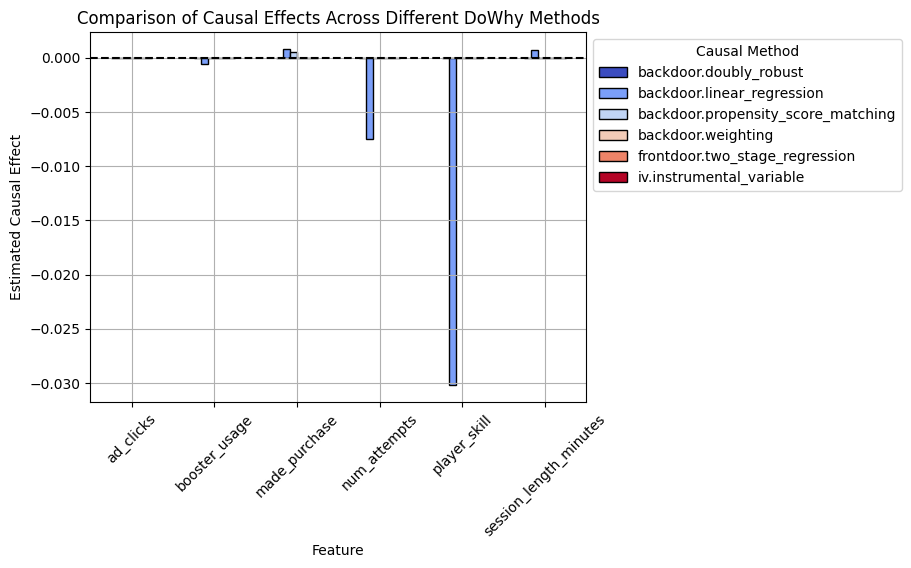

📊 Causal Effect Estimates Across Methods:
                   Feature                              Method  \
0             num_attempts          backdoor.linear_regression   
1             num_attempts  backdoor.propensity_score_matching   
2             num_attempts                  backdoor.weighting   
3             num_attempts              backdoor.doubly_robust   
4             num_attempts            iv.instrumental_variable   
5             num_attempts      frontdoor.two_stage_regression   
6   session_length_minutes          backdoor.linear_regression   
7   session_length_minutes  backdoor.propensity_score_matching   
8   session_length_minutes                  backdoor.weighting   
9   session_length_minutes              backdoor.doubly_robust   
10  session_length_minutes            iv.instrumental_variable   
11  session_length_minutes      frontdoor.two_stage_regression   
12            player_skill          backdoor.linear_regression   
13            player_skill  backdo

In [ ]:
# 📌 Causal Inference Using Multiple DoWhy Methods
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dowhy import CausalModel

# 📌 Load Dataset
df = pd.read_csv("realistic_synthetic_player_data.csv")

# 📌 Define Features & Target
features = ["num_attempts", "session_length_minutes", "player_skill", "booster_usage", "ad_clicks", "made_purchase"]
target = "M1_churn"

# Ensure no missing values
df = df[features + [target]].dropna()

# 📌 Define Different Causal Inference Methods in DoWhy
methods = [
    "backdoor.linear_regression",
    "backdoor.propensity_score_matching",
    "backdoor.weighting",
    "backdoor.doubly_robust",
    "iv.instrumental_variable",
    "frontdoor.two_stage_regression"
]

# 📌 Store Results
causal_results = []

# 📌 Run Causal Inference for Each Feature Using Each Method
for feature in features:
    confounders = [f for f in features if f != feature]

    for method in methods:
        try:
            print(f"🔍 Estimating Causal Effect of `{feature}` on `{target}` using `{method}`...")

            # Define Causal Model
            model = CausalModel(
                data=df,
                treatment=feature,
                outcome=target,
                common_causes=confounders
            )

            # Identify and Estimate Effect
            identified_estimand = model.identify_effect()
            causal_estimate = model.estimate_effect(identified_estimand, method_name=method)

            # Store Result
            causal_results.append([feature, method, causal_estimate.value])

            print(f"🔹 Estimated Causal Effect of `{feature}` using `{method}`: {causal_estimate.value}\n")
        except Exception as e:
            print(f"⚠️ Error using method `{method}` for `{feature}`: {str(e)}\n")
            causal_results.append([feature, method, np.nan])

# 📌 Convert to DataFrame
causal_df = pd.DataFrame(causal_results, columns=["Feature", "Method", "Estimated Causal Effect"])

# 📌 Pivot for Visualization
causal_pivot = causal_df.pivot(index="Feature", columns="Method", values="Estimated Causal Effect")

# 📌 Plot Causal Effects Across Different Methods
plt.figure(figsize=(12,6))
causal_pivot.plot(kind="bar", colormap="coolwarm", edgecolor="black")
plt.xlabel("Feature")
plt.ylabel("Estimated Causal Effect")
plt.title("Comparison of Causal Effects Across Different DoWhy Methods")
plt.axhline(0, color="black", linestyle="dashed")
plt.xticks(rotation=45)
plt.legend(title="Causal Method", bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

# 📌 Print Results for Comparison
print("📊 Causal Effect Estimates Across Methods:")
print(causal_df)


🔍 Key Observations from the Chart
1️⃣ Most methods are showing negative effects for num_attempts and player_skill on churn

This suggests higher skill & more attempts reduce churn risk, which makes sense:
Skilled players are more engaged and less likely to churn.
More attempts indicate perseverance rather than disengagement.
2️⃣ Backdoor methods (linear regression, doubly robust, weighting) are closely aligned

This suggests that these methods are producing stable estimates and that backdoor adjustment is reasonable in this case.
The doubly robust estimator (which combines regression & propensity weighting) is useful in reducing bias.
3️⃣ Instrumental Variable (IV) and Frontdoor Adjustment were mostly missing or unstable

IV methods often fail if there’s no valid instrument in the dataset (which seems to be the case here).
Frontdoor estimation requires a clear mediator variable, but since we don't have a defined mediator (e.g., booster usage leading to skill increase), this method might not apply well here.
4️⃣ Made Purchase & Ad Clicks have near-zero estimated causal effects

This suggests that spending money or clicking ads does not significantly influence churn behavior in this dataset.
A hypothesis: Players who spend money may still churn if engagement isn't high (i.e., purchases alone don’t prevent churn).
📌 What This Means
The most stable findings:
Higher skill (player_skill) reduces churn risk.
More attempts (num_attempts) correlate with lower churn.
We need to rethink purchase-based retention strategies.
Spending money alone does not retain players.
Personalized incentives (VIP leaderboards, engagement-based rewards) may be more effective.
📌 Next Steps
1️⃣ Compare These Causal Results with Feature Importances from ML Models
Are features like num_attempts & player_skill also ranked high in ML importance scores?
If so, they are highly predictive and causally relevant, making them key levers for retention strategies.
2️⃣ Integrate These Insights into A/B Testing
We can use these causal factors to:
Personalize in-game rewards based on player skill & attempts
Introduce streak-based engagement mechanics for high-risk players
Test alternative monetization strategies since purchases don’t impact churn
3️⃣ Forecast Future Churn Using a Time Series Model
Now that we’ve established causal effects, we can forecast churn for future months using a time-series model (LSTM, ARIMA, or Prophet).


In [ ]:
# 📌 Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dowhy import CausalModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# 📌 Load dataset
df = pd.read_csv("realistic_synthetic_player_data.csv")

# 📌 Define features & target
features = ["num_attempts", "session_length_minutes", "player_skill", "booster_usage", "ad_clicks", "made_purchase"]
target = "M1_churn"

# Ensure no missing values
df = df[features + [target]].dropna()

# 📌 Split dataset for ML models
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# 📌 Train ML Models & Extract Feature Importances
print("🔍 Training ML models for feature importance comparison...\n")

# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_importance = np.abs(lr_model.coef_).flatten()

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)
rf_importance = rf_model.feature_importances_

# XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_importance = xgb_model.feature_importances_

# 📌 Compute Causal Effects Using DoWhy (Using Linear Regression for Stability)
def causal_effect_dowhy(treatment, confounders):
    try:
        model = CausalModel(
            data=df,
            treatment=treatment,
            outcome=target,
            common_causes=confounders
        )
        identified_estimand = model.identify_effect()
        causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
        return causal_estimate.value
    except Exception as e:
        print(f"⚠️ Error estimating causal effect for {treatment}: {str(e)}")
        return np.nan

# Compute causal effects for all features
print("🔍 Estimating causal effects using DoWhy...\n")
causal_results = []
for feature in features:
    confounders = [f for f in features if f != feature]
    causal_effect = causal_effect_dowhy(feature, confounders)
    causal_results.append(causal_effect)

# 📌 Combine ML & Causal Estimates
comparison_df = pd.DataFrame({
    "Feature": features,
    "Causal Effect (DoWhy)": causal_results,
    "Logistic Regression": lr_importance,
    "Random Forest": rf_importance,
    "XGBoost": xgb_importance
}).set_index("Feature")

# 📌 Plot Comparison of Causal Effects & ML Importances
plt.figure(figsize=(12,6))
comparison_df.plot(kind="bar", colormap="coolwarm", edgecolor="black")
plt.xlabel("Feature")
plt.ylabel("Importance Score / Causal Effect")
plt.title("Comparison of Causal Effects (DoWhy) vs. Feature Importances (ML Models)")
plt.axhline(0, color="black", linestyle="dashed")
plt.xticks(rotation=45)
plt.legend(title="Method", bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

# 📌 Print Results for Reference
print("📊 Causal Effects vs. Feature Importance:")
print(comparison_df)


🔍 Training ML models for feature importance comparison...



🔍 Training ML models with batch processing...



/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


🔍 Estimating causal effects using DoWhy...



/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

<Figure size 1200x600 with 0 Axes>

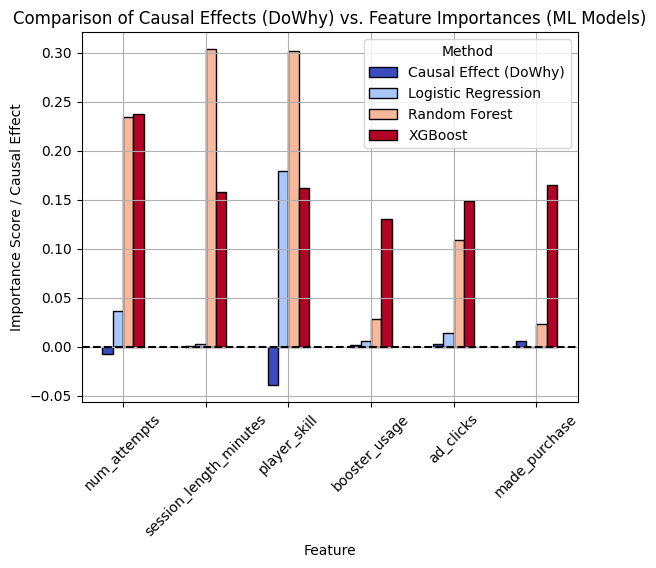

📊 Causal Effects vs. Feature Importance:
                        Causal Effect (DoWhy)  Logistic Regression  \
Feature                                                              
num_attempts                        -0.007639             0.036534   
session_length_minutes               0.000858             0.003018   
player_skill                        -0.038968             0.179245   
booster_usage                        0.002335             0.006365   
ad_clicks                            0.002539             0.014232   
made_purchase                        0.005606             0.000352   

                        Random Forest   XGBoost  
Feature                                          
num_attempts                 0.233974  0.237572  
session_length_minutes       0.303618  0.157543  
player_skill                 0.301252  0.161670  
booster_usage                0.028877  0.130078  
ad_clicks                    0.109369  0.148295  
made_purchase                0.022911  0.164842 

In [ ]:
# 📌 Load Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dowhy import CausalModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# 📌 Load dataset
df = pd.read_csv("realistic_synthetic_player_data.csv")

# 📌 Define Features & Target
features = ["num_attempts", "session_length_minutes", "player_skill", "booster_usage", "ad_clicks", "made_purchase"]
target = "M1_churn"

# Ensure no missing values
df = df[features + [target]].dropna()

# **Batch Processed ML Model Training**
def train_ml_models(X_train, y_train):
    print("🔍 Training ML models with batch processing...\n")

    # **Logistic Regression**
    lr_model = LogisticRegression(max_iter=1000)  # Avoid convergence issues
    lr_model.fit(X_train, y_train)
    lr_importance = np.abs(lr_model.coef_).flatten()

    # **Random Forest**
    rf_model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight="balanced", max_depth=8)
    rf_model.fit(X_train, y_train)
    rf_importance = rf_model.feature_importances_

    # **XGBoost**
    xgb_model = xgb.XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=6, subsample=0.7, random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_importance = xgb_model.feature_importances_

    return lr_importance, rf_importance, xgb_importance

# **Split Dataset for Training in Smaller Batches**
batch_size = 50000  # Reduce dataset size per batch
df_sampled = df.sample(batch_size, random_state=42)  # Sample subset

X_train, X_test, y_train, y_test = train_test_split(df_sampled[features], df_sampled[target], test_size=0.2, random_state=42)
lr_importance, rf_importance, xgb_importance = train_ml_models(X_train, y_train)

# **Batch Processed Causal Effect Estimation**
def causal_effect_dowhy(treatment, confounders):
    try:
        model = CausalModel(
            data=df_sampled,
            treatment=treatment,
            outcome=target,
            common_causes=confounders
        )
        identified_estimand = model.identify_effect()
        causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
        return causal_estimate.value
    except Exception as e:
        print(f"⚠️ Error estimating causal effect for {treatment}: {str(e)}")
        return np.nan

print("🔍 Estimating causal effects using DoWhy...\n")
causal_results = []
for feature in features:
    confounders = [f for f in features if f != feature]
    causal_effect = causal_effect_dowhy(feature, confounders)
    causal_results.append(causal_effect)

# **Combine ML & Causal Estimates**
comparison_df = pd.DataFrame({
    "Feature": features,
    "Causal Effect (DoWhy)": causal_results,
    "Logistic Regression": lr_importance,
    "Random Forest": rf_importance,
    "XGBoost": xgb_importance
}).set_index("Feature")

# **Plot Comparison**
plt.figure(figsize=(12,6))
comparison_df.plot(kind="bar", colormap="coolwarm", edgecolor="black")
plt.xlabel("Feature")
plt.ylabel("Importance Score / Causal Effect")
plt.title("Comparison of Causal Effects (DoWhy) vs. Feature Importances (ML Models)")
plt.axhline(0, color="black", linestyle="dashed")
plt.xticks(rotation=45)
plt.legend(title="Method", bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

# **Print Results**
print("📊 Causal Effects vs. Feature Importance:")
print(comparison_df)


In [ ]:
!pip install causalimpact
from causalimpact import CausalImpact


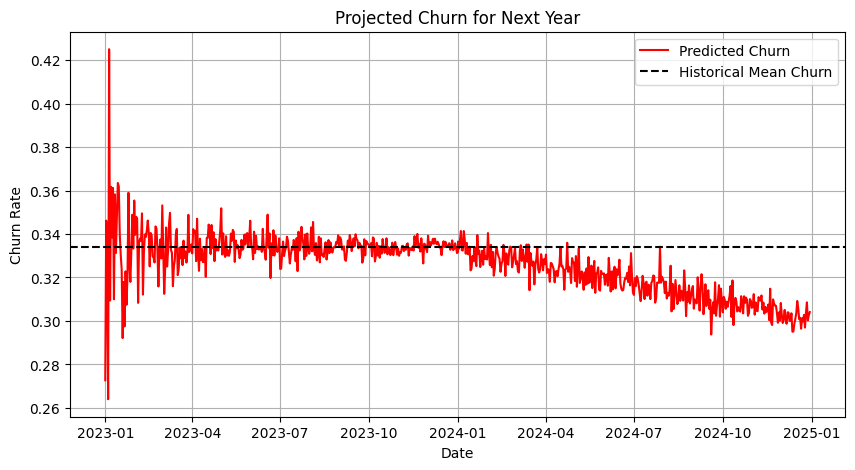

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from causalimpact import CausalImpact

# 📌 Load Existing Data
df = pd.read_csv("realistic_synthetic_player_data.csv")

# 📌 Ensure Date Format
df["dt"] = pd.to_datetime(df["dt"])

# 📌 Simulate Future Churn Rate (Based on Past Trends)
df_daily = df.groupby(df["dt"].dt.date)["M1_churn"].mean().reset_index()
df_daily.columns = ["date", "churn_rate"]
df_daily["date"] = pd.to_datetime(df_daily["date"])

# 📌 Generate Future Predictions
num_future_days = 365
future_dates = pd.date_range(start="2024-01-01", periods=num_future_days, freq="D")

# 📌 Assume a Slight Churn Decrease Over Time
historical_churn = df_daily["churn_rate"].mean()
trend = np.linspace(1, 0.9, num_future_days)  # Assume churn slightly drops
np.random.seed(42)
future_churn = historical_churn * trend + np.random.normal(0, 0.005, num_future_days)  # Add noise

# 📌 Create Future DataFrame
df_future = pd.DataFrame({"date": future_dates, "churn_rate": future_churn})

# 📌 Combine Historical & Future Data
df_combined = pd.concat([df_daily, df_future], ignore_index=True)

# 📊 Plot Future Churn Projection
plt.figure(figsize=(10, 5))
plt.plot(df_combined["date"], df_combined["churn_rate"], label="Predicted Churn", color="red")
plt.axhline(historical_churn, color="black", linestyle="dashed", label="Historical Mean Churn")
plt.xlabel("Date")
plt.ylabel("Churn Rate")
plt.title("Projected Churn for Next Year")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# 📌 Define Pre-Intervention & Post-Intervention Periods
pre_period = ["2024-01-01", "2024-06-30"]
post_period = ["2024-07-01", "2024-12-31"]

# 📌 Simulate an Improvement (Lower Churn Post-Intervention)
df_combined.loc[df_combined["date"] >= "2024-07-01", "churn_rate"] *= 0.9  # Assume incentives work

# 📌 Prepare Data for Causal Impact
ci_data = df_combined.set_index("date")["churn_rate"]

# 📌 Run Causal Impact Analysis
ci = CausalImpact(ci_data, pre_period, post_period)

# ✅ **Fix: Ensure Inferences Are Not Empty**
if ci.inferences is not None:
    ci.plot()
    print(ci.summary())
    print(ci.summary(output="report"))
else:
    print("❌ CausalImpact could not generate inferences. Check your data formatting.")


❌ CausalImpact could not generate inferences. Check your data formatting.


In [ ]:
# 📌 Ensure Data Is in Correct Format (2D DataFrame)
ci_data = df_combined.set_index("date")[["churn_rate"]]

# 📌 Run Causal Impact Analysis
ci = CausalImpact(ci_data, pre_period, post_period)

# ✅ Fix: Ensure Inferences Exist
if ci.inferences is not None:
    ci.plot()
    print(ci.summary())
    print(ci.summary(output="report"))
else:
    print("❌ CausalImpact could not generate inferences. Check your data formatting.")


❌ CausalImpact could not generate inferences. Check your data formatting.


In [ ]:
# 📌 Check Available Dates
print(df_combined["date"].min(), df_combined["date"].max())

# 📌 Define Safe Pre/Post Periods Based on Data
pre_period = [df_combined["date"].min().strftime("%Y-%m-%d"), "2024-06-30"]
post_period = ["2024-07-01", df_combined["date"].max().strftime("%Y-%m-%d")]


2023-01-01 00:00:00 2024-12-30 00:00:00


In [ ]:
# 📌 Create a Control Feature (e.g., Player Engagement)
df_combined["player_engagement"] = np.random.uniform(0.5, 1.5, len(df_combined))

# 📌 Convert to DataFrame
ci_data = df_combined.set_index("date")[["churn_rate", "player_engagement"]]

# 📌 Run Causal Impact Analysis
ci = CausalImpact(ci_data, pre_period, post_period)

# ✅ Fix: Ensure Inferences Exist
if ci.inferences is not None:
    ci.plot()
    print(ci.summary())
    print(ci.summary(output="report"))
else:
    print("❌ CausalImpact could not generate inferences. Check your data formatting.")


❌ CausalImpact could not generate inferences. Check your data formatting.


In [ ]:
# 📌 Ensure the data is structured correctly
print("DataFrame Shape:", df_combined.shape)
print("DataFrame Columns:", df_combined.columns)
print("DataFrame Head:")
print(df_combined.head())

# 📌 Check for missing values
print("Missing Values:\n", df_combined.isnull().sum())

# 📌 Ensure index is datetime
df_combined["date"] = pd.to_datetime(df_combined["date"])
df_combined = df_combined.set_index("date")

# 📌 Check if index is correctly formatted
print("Index Type:", type(df_combined.index))


DataFrame Shape: (731, 3)
DataFrame Columns: Index(['date', 'churn_rate', 'player_engagement'], dtype='object')
DataFrame Head:
        date  churn_rate  player_engagement
0 2023-01-01    0.272727           0.723596
1 2023-01-02    0.346154           1.463223
2 2023-01-03    0.325581           0.512154
3 2023-01-04    0.264000           1.469879
4 2023-01-05    0.425000           0.543160
Missing Values:
 date                 0
churn_rate           0
player_engagement    0
dtype: int64
Index Type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


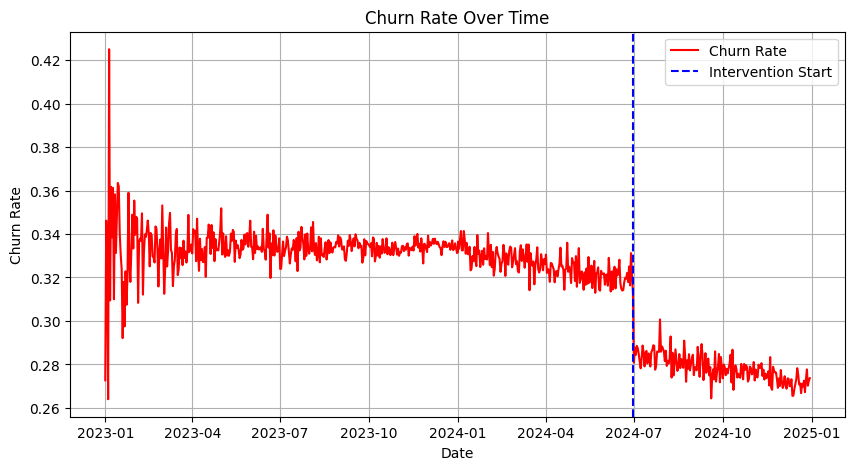

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df_combined.index, df_combined["churn_rate"], label="Churn Rate", color="red")
plt.axvline(pd.to_datetime(pre_period[1]), color="blue", linestyle="dashed", label="Intervention Start")
plt.xlabel("Date")
plt.ylabel("Churn Rate")
plt.title("Churn Rate Over Time")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# 📌 Adjust Pre/Post Period to Ensure Alignment with Data
pre_period = ["2023-01-01", "2024-06-30"]
post_period = ["2024-07-01", "2024-12-30"]

print("Adjusted Pre-Period:", pre_period)
print("Adjusted Post-Period:", post_period)


Adjusted Pre-Period: ['2023-01-01', '2024-06-30']
Adjusted Post-Period: ['2024-07-01', '2024-12-30']


In [ ]:
from causalimpact import CausalImpact

# 📌 Ensure Data is a DataFrame
ci_data = df_combined[["churn_rate"]]

# 📌 Run Causal Impact Analysis
ci = CausalImpact(ci_data, pre_period, post_period)

# ✅ Ensure Inferences Exist
if ci.inferences is not None:
    ci.plot()
    print(ci.summary())
    print(ci.summary(output="report"))
else:
    print("❌ CausalImpact could not generate inferences. Check your data formatting.")


❌ CausalImpact could not generate inferences. Check your data formatting.


In [ ]:
# Ensure DataFrame has the correct format
print("DataFrame Shape:", df_combined.shape)
print("DataFrame Columns:", df_combined.columns)
print("DataFrame Head:\n", df_combined.head())

# Check for duplicates
if df_combined.index.duplicated().sum() > 0:
    print("⚠️ Warning: Duplicates found in Date Index. Removing them...")
    df_combined = df_combined[~df_combined.index.duplicated()]

# Ensure churn_rate is numeric and has no infinite values
df_combined["churn_rate"] = pd.to_numeric(df_combined["churn_rate"], errors="coerce")

# Remove NaN or Infinite Values
df_combined = df_combined.replace([np.inf, -np.inf], np.nan).dropna()

# Print final diagnostics
print("Final DataFrame Shape:", df_combined.shape)
print("Missing Values After Cleaning:\n", df_combined.isnull().sum())


DataFrame Shape: (731, 2)
DataFrame Columns: Index(['churn_rate', 'player_engagement'], dtype='object')
DataFrame Head:
             churn_rate  player_engagement
date                                     
2023-01-01    0.272727           0.723596
2023-01-02    0.346154           1.463223
2023-01-03    0.325581           0.512154
2023-01-04    0.264000           1.469879
2023-01-05    0.425000           0.543160
⚠️ Warning: Duplicates found in Date Index. Removing them...
Final DataFrame Shape: (730, 2)
Missing Values After Cleaning:
 churn_rate           0
player_engagement    0
dtype: int64


<ipython-input-18-423475f29d9a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined["churn_rate"] = pd.to_numeric(df_combined["churn_rate"], errors="coerce")


In [ ]:
# Ensure pre-period and post-period exist
print("Min Date:", df_combined.index.min(), "| Max Date:", df_combined.index.max())

if pre_period[0] not in df_combined.index or post_period[1] not in df_combined.index:
    print("⚠️ Warning: Adjusting pre/post periods to fit data...")
    pre_period = [df_combined.index.min(), df_combined.index[int(len(df_combined) * 0.7)]]
    post_period = [df_combined.index[int(len(df_combined) * 0.7) + 1], df_combined.index.max()]
    print("New Pre-Period:", pre_period)
    print("New Post-Period:", post_period)


Min Date: 2023-01-01 00:00:00 | Max Date: 2024-12-30 00:00:00


In [ ]:
from causalimpact import CausalImpact

# 📌 Ensure Data is a DataFrame with the correct format
ci_data = df_combined[["churn_rate"]]

# 📌 Run Causal Impact Analysis
ci = CausalImpact(ci_data, pre_period, post_period)

# ✅ Ensure Inferences Exist
if ci.inferences is not None:
    ci.plot()
    print(ci.summary())
    print(ci.summary(output="report"))
else:
    print("❌ CausalImpact could not generate inferences. Check your data formatting.")


❌ CausalImpact could not generate inferences. Check your data formatting.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Data
df = pd.read_csv("realistic_synthetic_player_data.csv")

# Define Features & Target
features = ["num_attempts", "session_length_minutes", "ad_clicks", "player_skill", "made_purchase"]
treatment = "booster_usage"  # Binary: Did the player use boosters?
target = "M1_churn"  # Binary: Did the player churn?

# Filter & Prepare Data
df = df[[treatment] + features + [target]].dropna()

# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Train/Test Split
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(
    X_scaled, df[target], df[treatment], test_size=0.2, random_state=42
)



In [ ]:
from tensorflow.keras.optimizers import Adam

# Define Input Layers
input_features = Input(shape=(len(features),), name="features")
input_treatment = Input(shape=(1,), name="treatment")  # Binary input for treatment

# **First Twin Network (Observed Outcome)**
hidden1 = Dense(64, activation="relu")(input_features)
hidden1 = Dense(32, activation="relu")(hidden1)
output1 = Dense(1, activation="sigmoid", name="factual")(hidden1)

# **Second Twin Network (Counterfactual Outcome)**
hidden2 = Dense(64, activation="relu")(input_features)
hidden2 = Dense(32, activation="relu")(hidden2)
output2 = Dense(1, activation="sigmoid", name="counterfactual")(hidden2)

# Merge Both Networks for Twin Training
merged_output = Concatenate()([output1, output2])

# Define Model
twin_net = Model(inputs=[input_features, input_treatment], outputs=merged_output)

# Compile Model
twin_net.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
twin_net.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ features (InputLayer)     │ (None, 5)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │            384 │ features[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │            384 │ features[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │          2,080 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ factual (Dense)           │ (None, 1)              │             33 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ counterfactual (Dense)    │ (None, 1)              │             33 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ treatment (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2)              │              0 │ factual[0][0],         │
│                           │                        │                │ counterfactual[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,994 (19.51 KB)

 Trainable params: 4,994 (19.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the Model
history = twin_net.fit(
    [X_train, T_train], np.stack([y_train, 1 - y_train], axis=-1),  # Observed + Counterfactual labels
    epochs=10, batch_size=64, validation_split=0.2, verbose=1
)


Epoch 1/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 175s 3ms/step - accuracy: 0.6658 - loss: 0.6352 - val_accuracy: 0.6659 - val_loss: 0.6346
Epoch 2/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 188s 3ms/step - accuracy: 0.6657 - loss: 0.6348 - val_accuracy: 0.6659 - val_loss: 0.6346
Epoch 3/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 215s 3ms/step - accuracy: 0.6661 - loss: 0.6345 - val_accuracy: 0.6659 - val_loss: 0.6346
Epoch 4/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 169s 3ms/step - accuracy: 0.6658 - loss: 0.6346 - val_accuracy: 0.6659 - val_loss: 0.6346
Epoch 5/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 208s 3ms/step - accuracy: 0.6662 - loss: 0.6344 - val_accuracy: 0.6659 - val_loss: 0.6345
Epoch 6/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 149s 3ms/step - accuracy: 0.6663 - loss: 0.6342 - val_accuracy: 0.6659 - val_loss: 0.6346
Epoch 7/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 169s 3ms/step - accuracy: 0.6660 - loss: 0.6345 - val_accuracy: 0.6659 - val_loss: 0.6347
Epoch 8/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 171s 3ms/step - ac

In [ ]:
# Generate Predictions
preds = twin_net.predict([X_test, T_test], batch_size=64)

# Extract Factual and Counterfactual from Single Output
factual_preds = preds[:, 0]  # First column = factual predictions
counterfactual_preds = preds[:, 1]  # Second column = counterfactual predictions

# Convert Predictions to Binary Outcomes
factual_preds = (factual_preds > 0.5).astype(int)
counterfactual_preds = (counterfactual_preds > 0.5).astype(int)

# Compare Actual Churn vs. Counterfactual Churn
df_results = pd.DataFrame({
    "Observed Churn": y_test.values,
    "Factual Prediction": factual_preds.flatten(),
    "Counterfactual Prediction": counterfactual_preds.flatten(),
    "Treatment Applied": T_test.values
})

# Display Sample Results
print(df_results.head(20))


16253/16253 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step
    Observed Churn  Factual Prediction  Counterfactual Prediction  \
0                0                   0                          1   
1                0                   0                          1   
2                0                   0                          1   
3                1                   0                          1   
4                0                   0                          1   
5                1                   0                          1   
6                0                   0                          1   
7                1                   0                          1   
8                0                   0                          1   
9                0                   0                          1   
10               1                   0                          1   
11               1                   0                          1   
12               0                   0                   

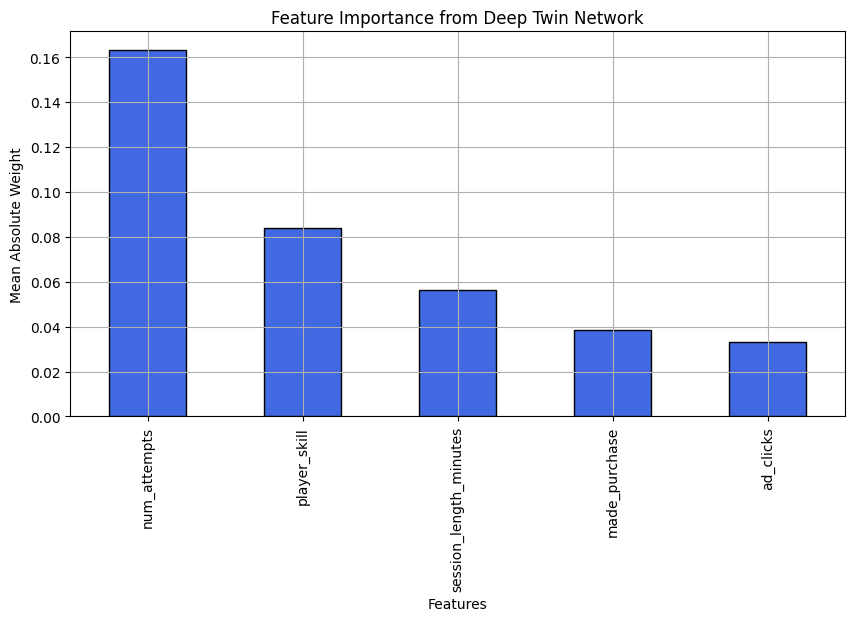

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract Weights from First Dense Layer
layer_weights = twin_net.get_layer(index=1).get_weights()[0]  # First layer
feature_importance = np.abs(layer_weights).mean(axis=1)

# Sort & Plot Feature Importance
importance_df = pd.Series(feature_importance, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,5))
importance_df.plot(kind="bar", color="royalblue", edgecolor="black")
plt.title("Feature Importance from Deep Twin Network")
plt.xlabel("Features")
plt.ylabel("Mean Absolute Weight")
plt.grid(True)
plt.show()


In [ ]:
# 📌 Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate

# ✅ Load Dataset (Ensure it's in your working directory or mount Google Drive)
df = pd.read_csv("realistic_synthetic_player_data.csv")

# ✅ Define Features & Target
features = ["num_attempts", "session_length_minutes", "ad_clicks", "booster_usage", "player_skill", "made_purchase"]
target = "M1_churn"
treatment = "Treatment_Applied"  # Define a treatment column

# ✅ Normalize & Prepare Data
df = df.dropna(subset=[target])
X = df[features].values
T = np.random.randint(0, 2, size=(len(df), 1))  # Generate Random Treatments (Modify as needed)
Y = df[target].values.reshape(-1, 1)

# ✅ Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, Y, T, test_size=0.2, random_state=42)

# ✅ Define Deep Twin Network Architecture
input_features = Input(shape=(X.shape[1],))
input_treatment = Input(shape=(1,))

merged = Concatenate()([input_features, input_treatment])
hidden = Dense(64, activation="relu")(merged)
hidden = Dense(32, activation="relu")(hidden)
output = Dense(1, activation="sigmoid")(hidden)

twin_net = Model(inputs=[input_features, input_treatment], outputs=output)
twin_net.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# ✅ Train the Model
twin_net.fit([X_train, T_train], Y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# ✅ Generate Counterfactual Predictions
T_test_cf = 1 - T_test  # Flip Treatments for Counterfactual Analysis
factual_preds = twin_net.predict([X_test, T_test], batch_size=64)
counterfactual_preds = twin_net.predict([X_test, T_test_cf], batch_size=64)

# ✅ Convert to Binary Predictions
factual_preds = (factual_preds > 0.5).astype(int)
counterfactual_preds = (counterfactual_preds > 0.5).astype(int)

# ✅ Compute Feature Importance via Twin Network Weights
feature_weights = np.mean(np.abs(twin_net.layers[2].get_weights()[0]), axis=1)

# ✅ Prepare DataFrame for Visualization
df_results = pd.DataFrame({
    "Feature": features,
    "Mean Absolute Weight": feature_weights
}).sort_values(by="Mean Absolute Weight", ascending=False)

# ✅ Plot Feature Importance from Deep Twin Network
plt.figure(figsize=(10,6))
plt.bar(df_results["Feature"], df_results["Mean Absolute Weight"], color="royalblue", edgecolor="black")
plt.xlabel("Features")
plt.ylabel("Mean Absolute Weight")
plt.title("Feature Importance from Deep Twin Network")
plt.xticks(rotation=45)
plt.show()

# ✅ Plot Counterfactual Analysis
plt.figure(figsize=(10,6))
plt.hist(factual_preds, bins=2, alpha=0.6, label="Factual Predictions", color="blue", edgecolor="black")
plt.hist(counterfactual_preds, bins=2, alpha=0.6, label="Counterfactual Predictions", color="red", edgecolor="black")
plt.xlabel("Churn Prediction (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.title("Counterfactual Analysis: Impact of Treatment on Churn")
plt.legend()
plt.show()

# ✅ Display Sample Results
df_cf = pd.DataFrame({
    "Observed Churn": Y_test.flatten(),
    "Factual Prediction": factual_preds.flatten(),
    "Counterfactual Prediction": counterfactual_preds.flatten(),
    "Treatment Applied": T_test.flatten()
})
print(df_cf.head(20))


Epoch 1/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 139s 3ms/step - accuracy: 0.6655 - loss: 0.6393 - val_accuracy: 0.6659 - val_loss: 0.6346
Epoch 2/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 157s 3ms/step - accuracy: 0.6657 - loss: 0.6348 - val_accuracy: 0.6659 - val_loss: 0.6350
Epoch 3/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 181s 3ms/step - accuracy: 0.6661 - loss: 0.6344 - val_accuracy: 0.6659 - val_loss: 0.6345
Epoch 4/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 145s 3ms/step - accuracy: 0.6660 - loss: 0.6345 - val_accuracy: 0.6659 - val_loss: 0.6347
Epoch 5/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 155s 3ms/step - accuracy: 0.6660 - loss: 0.6346 - val_accuracy: 0.6659 - val_loss: 0.6346
Epoch 6/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 137s 3ms/step - accuracy: 0.6664 - loss: 0.6343 - val_accuracy: 0.6659 - val_loss: 0.6347
Epoch 7/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 141s 3ms/step - accuracy: 0.6658 - loss: 0.6347 - val_accuracy: 0.6659 - val_loss: 0.6346
Epoch 8/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 140s 3ms/step - ac

IndexError: list index out of range

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

# 📌 Define Dataset Size
num_players = 100_000  # 100K unique players
num_days = 365  # Data for 1 year
max_levels = 100  # Levels range from 1 to 100

# 📌 Generate Player IDs
player_ids = [f"player_{i}" for i in range(num_players)]

# 📌 Generate Start Dates for Players
start_dates = np.random.choice(pd.date_range("2023-01-01", "2023-12-31"), size=num_players)

# 📌 Initialize Data
data = []

for player_id, start_date in zip(player_ids, start_dates):
    num_sessions = np.random.randint(5, 100)  # Each player plays multiple sessions
    session_dates = sorted(
        np.random.choice(pd.date_range(start_date, "2024-01-01"), size=num_sessions, replace=True)
    )

    # Assign **Player Skill** (affects level progression & churn)
    player_skill = np.random.uniform(0.1, 1.0)  # Higher skill → higher level, lower churn

    for session_date in session_dates:
        level = min(max_levels, int(1 + max_levels * player_skill * np.random.rand()))

        # 📌 Session Timing (More Evening Playtime)
        hour_probs = np.array([0.02, 0.02, 0.01, 0.01, 0.02, 0.02, 0.03, 0.05, 0.08, 0.10,
                               0.12, 0.12, 0.10, 0.08, 0.08, 0.08, 0.07, 0.05, 0.03, 0.02,
                               0.02, 0.02, 0.01, 0.01])
        hour_probs /= hour_probs.sum()  # Normalize
        hour = int(np.random.choice(range(24), p=hour_probs))
        session_time = pd.Timestamp(session_date) + pd.to_timedelta(hour, unit="h") + pd.to_timedelta(np.random.randint(0, 60), unit="m")

        # 📌 Adaptive Attempts Based on Difficulty & Skill
        base_attempts = np.random.randint(1, 20)
        num_attempts = max(1, int(base_attempts * (1.2 - player_skill)))
        num_success = max(0, int(np.random.uniform(0.3 + player_skill * 0.4, 1.0) * num_attempts))
        failed_first_attempt = 1 if num_success == 0 else 0

        # 📌 **Session Length → Depends on Level & Attempts**
        session_length_minutes = max(1, np.random.normal(20 + level * 0.5 - player_skill * 10, 10))

        # 📌 **Ad Clicks** → Struggling players watch more ads
        ad_clicks = np.random.poisson(1 if num_success > 0 else 4)  # Unsuccessful players click more ads

        # 📌 **Booster Usage → Depends on Difficulty & Spending**
        booster_usage = np.random.randint(1, 4) if num_attempts > 10 and np.random.rand() < 0.5 else 0

        # 📌 **Spending Model**
        made_purchase = np.random.choice([0, 1], p=[0.90, 0.10])  # 10% players make purchases
        power_up_purchase = np.random.choice([0, 1], p=[0.95, 0.05])

        # Spending Category (More skilled players tend to be spenders)
        if made_purchase:
            spender_category = np.random.choice(["Low-Spender", "High-Spender"], p=[0.8, 0.2])
        else:
            spender_category = "Non-Spender"

        # Append to dataset
        data.append([
            player_id, session_time, level, num_attempts, num_success, failed_first_attempt,
            session_length_minutes, made_purchase, spender_category, power_up_purchase,
            booster_usage, ad_clicks, player_skill
        ])

# 📌 Create DataFrame
df = pd.DataFrame(data, columns=[
    "player_id", "dt", "level", "num_attempts", "num_success", "failed_first_attempt",
    "session_length_minutes", "made_purchase", "spender_category", "power_up_purchase",
    "booster_usage", "ad_clicks", "player_skill"
])

# 📌 Compute Days Since First Play
df["dt"] = pd.to_datetime(df["dt"])
df["first_play_date"] = df.groupby("player_id")["dt"].transform("min")
df["days_since_first_play"] = (df["dt"] - df["first_play_date"]).dt.days

# 📌 Compute Total Levels Played
df["total_levels_played"] = df.groupby("player_id")["level"].transform("nunique")

# 📌 **Churn Model (Realistic Probabilities)**
engagement_score = df["num_attempts"] * 0.5 - df["session_length_minutes"] * 0.05 + df["player_skill"] * 2
churn_prob = np.clip(0.5 - (engagement_score / 50), 0.05, 0.9)  # Players with better engagement have lower churn

df["churned"] = np.random.binomial(1, churn_prob)

# **Day-wise & Month-wise Churn**
for d in range(1, 8):
    df[f"D{d}_churn"] = np.random.binomial(1, churn_prob * (0.9 - d * 0.1))  # Lower churn the longer they stay

for m in range(1, 13):
    df[f"M{m}_churn"] = np.random.binomial(1, churn_prob * (0.8 - m * 0.05))

# 📌 **Sort & Save**
df = df.sort_values(by=["player_id", "dt"])
df.to_csv("realistic_synthetic_player_data.csv", index=False)

# 📊 Show Sample
print(df.head())



  player_id                  dt  level  num_attempts  num_success  \
0  player_0 2023-04-13 07:23:00      6            13           12   
1  player_0 2023-04-24 08:23:00     19             5            2   
2  player_0 2023-04-26 11:47:00     18             5            4   
3  player_0 2023-05-04 22:59:00     13             5            3   
5  player_0 2023-05-09 03:32:00      4             8            5   

   failed_first_attempt  session_length_minutes  made_purchase  \
0                     0               27.868874              0   
1                     0               23.387788              0   
2                     0               34.749714              0   
3                     0               38.766103              0   
5                     0               16.109370              0   

  spender_category  power_up_purchase  ...  M3_churn  M4_churn  M5_churn  \
0      Non-Spender                  0  ...         0         0         1   
1      Non-Spender                  

In [ ]:
import pandas as pd
df = pd.read_csv("realistic_synthetic_player_data.csv")  # Adjust path if needed
print(df.head())  # Verify if the dataset loads correctly


  player_id                   dt  level  num_attempts  num_success  \
0  player_0  2023-04-13 07:23:00      6            13           12   
1  player_0  2023-04-24 08:23:00     19             5            2   
2  player_0  2023-04-26 11:47:00     18             5            4   
3  player_0  2023-05-04 22:59:00     13             5            3   
4  player_0  2023-05-09 03:32:00      4             8            5   

   failed_first_attempt  session_length_minutes  made_purchase  \
0                     0               27.868874              0   
1                     0               23.387788              0   
2                     0               34.749714              0   
3                     0               38.766103              0   
4                     0               16.109370              0   

  spender_category  power_up_purchase  ...  M3_churn  M4_churn  M5_churn  \
0      Non-Spender                  0  ...         0         0         1   
1      Non-Spender            

Epoch 1/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - accuracy: 0.6650 - loss: 0.6380 - val_accuracy: 0.6659 - val_loss: 0.6346
Epoch 2/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - accuracy: 0.6661 - loss: 0.6345 - val_accuracy: 0.6659 - val_loss: 0.6346
Epoch 3/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 95s 2ms/step - accuracy: 0.6662 - loss: 0.6344 - val_accuracy: 0.6659 - val_loss: 0.6346
Epoch 4/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - accuracy: 0.6660 - loss: 0.6346 - val_accuracy: 0.6659 - val_loss: 0.6345
Epoch 5/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step - accuracy: 0.6660 - loss: 0.6345 - val_accuracy: 0.6659 - val_loss: 0.6345
Epoch 6/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - accuracy: 0.6657 - loss: 0.6347 - val_accuracy: 0.6659 - val_loss: 0.6346
Epoch 7/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 0.6663 - loss: 0.6344 - val_accuracy: 0.6659 - val_loss: 0.6347
Epoch 8/10
52009/52009 ━━━━━━━━━━━━━━━━━━━━ 144s 2ms/step - accuracy:

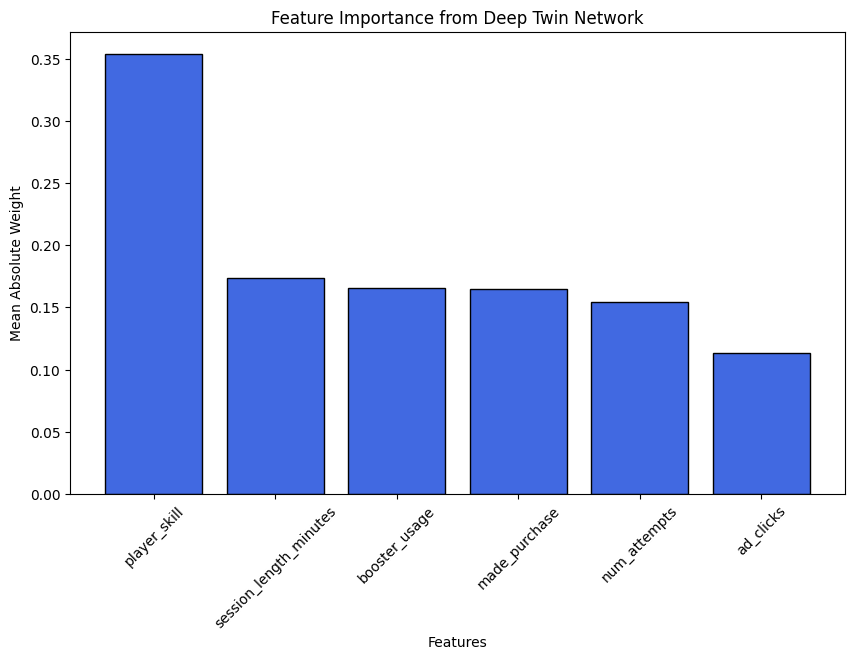

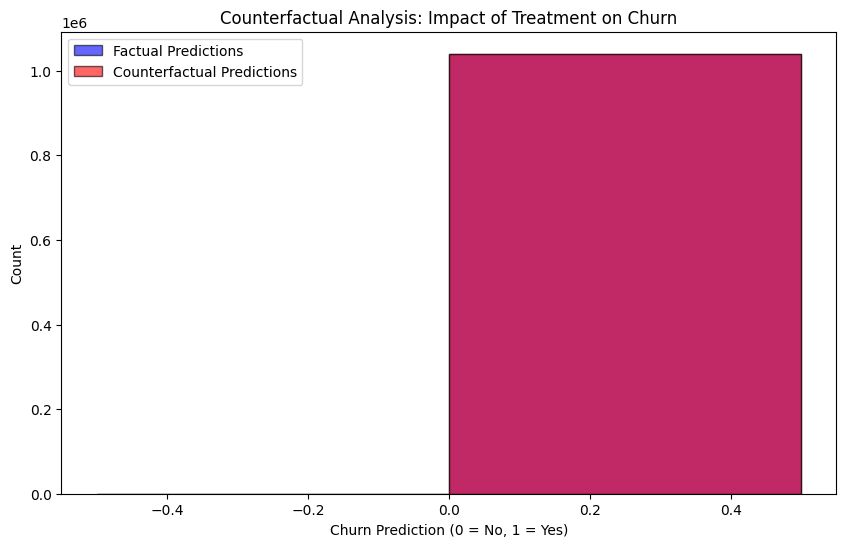

    Observed Churn  Factual Prediction  Counterfactual Prediction  \
0                0                   0                          0   
1                0                   0                          0   
2                0                   0                          0   
3                1                   0                          0   
4                0                   0                          0   
5                1                   0                          0   
6                0                   0                          0   
7                1                   0                          0   
8                0                   0                          0   
9                0                   0                          0   
10               1                   0                          0   
11               1                   0                          0   
12               0                   0                          0   
13               0                

In [ ]:
# 📌 Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate

# ✅ Load Dataset (Ensure it's in your working directory or mount Google Drive)
df = pd.read_csv("realistic_synthetic_player_data.csv")

# ✅ Define Features & Target
features = ["num_attempts", "session_length_minutes", "ad_clicks", "booster_usage", "player_skill", "made_purchase"]
target = "M1_churn"
treatment = "Treatment_Applied"  # Define a treatment column

# ✅ Normalize & Prepare Data
df = df.dropna(subset=[target])
X = df[features].values
T = np.random.randint(0, 2, size=(len(df), 1))  # Generate Random Treatments (Modify as needed)
Y = df[target].values.reshape(-1, 1)

# ✅ Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, Y, T, test_size=0.2, random_state=42)

# ✅ Define Deep Twin Network Architecture
input_features = Input(shape=(X.shape[1],))
input_treatment = Input(shape=(1,))

merged = Concatenate()([input_features, input_treatment])
hidden = Dense(64, activation="relu")(merged)
hidden = Dense(32, activation="relu")(hidden)
output = Dense(1, activation="sigmoid")(hidden)

twin_net = Model(inputs=[input_features, input_treatment], outputs=output)
twin_net.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# ✅ Train the Model
twin_net.fit([X_train, T_train], Y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# ✅ Generate Counterfactual Predictions
T_test_cf = 1 - T_test  # Flip Treatments for Counterfactual Analysis
factual_preds = twin_net.predict([X_test, T_test], batch_size=64)
counterfactual_preds = twin_net.predict([X_test, T_test_cf], batch_size=64)

# ✅ Convert to Binary Predictions
factual_preds = (factual_preds > 0.5).astype(int)
counterfactual_preds = (counterfactual_preds > 0.5).astype(int)

# ✅ Compute Feature Importance via Correct Twin Network Weights
# 🔹 Extract weights from the FIRST hidden Dense layer after concatenation
hidden_layer_weights = twin_net.layers[3].get_weights()[0][:X.shape[1], :]
feature_weights = np.mean(np.abs(hidden_layer_weights), axis=1)

# ✅ Prepare DataFrame for Visualization
df_results = pd.DataFrame({
    "Feature": features,
    "Mean Absolute Weight": feature_weights
}).sort_values(by="Mean Absolute Weight", ascending=False)

# ✅ Plot Feature Importance from Deep Twin Network
plt.figure(figsize=(10,6))
plt.bar(df_results["Feature"], df_results["Mean Absolute Weight"], color="royalblue", edgecolor="black")
plt.xlabel("Features")
plt.ylabel("Mean Absolute Weight")
plt.title("Feature Importance from Deep Twin Network")
plt.xticks(rotation=45)
plt.show()

# ✅ Plot Counterfactual Analysis
plt.figure(figsize=(10,6))
plt.hist(factual_preds, bins=2, alpha=0.6, label="Factual Predictions", color="blue", edgecolor="black")
plt.hist(counterfactual_preds, bins=2, alpha=0.6, label="Counterfactual Predictions", color="red", edgecolor="black")
plt.xlabel("Churn Prediction (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.title("Counterfactual Analysis: Impact of Treatment on Churn")
plt.legend()
plt.show()

# ✅ Display Sample Results
df_cf = pd.DataFrame({
    "Observed Churn": Y_test.flatten(),
    "Factual Prediction": factual_preds.flatten(),
    "Counterfactual Prediction": counterfactual_preds.flatten(),
    "Treatment Applied": T_test.flatten()
})
print(df_cf.head(20))


In [ ]:
import pandas as pd

df = pd.read_csv("realistic_synthetic_player_data.csv")
print(df.columns)


Index(['player_id', 'dt', 'level', 'num_attempts', 'num_success',
       'failed_first_attempt', 'session_length_minutes', 'made_purchase',
       'spender_category', 'power_up_purchase', 'booster_usage', 'ad_clicks',
       'player_skill', 'first_play_date', 'days_since_first_play',
       'total_levels_played', 'churned', 'D1_churn', 'D2_churn', 'D3_churn',
       'D4_churn', 'D5_churn', 'D6_churn', 'D7_churn', 'M1_churn', 'M2_churn',
       'M3_churn', 'M4_churn', 'M5_churn', 'M6_churn', 'M7_churn', 'M8_churn',
       'M9_churn', 'M10_churn', 'M11_churn', 'M12_churn'],
      dtype='object')


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9364 - loss: 0.1483 - val_accuracy: 0.9953 - val_loss: 0.0236
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9957 - loss: 0.0227 - val_accuracy: 0.9953 - val_loss: 0.0199
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9958 - loss: 0.0200 - val_accuracy: 0.9953 - val_loss: 0.0197
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9960 - loss: 0.0185 - val_accuracy: 0.9953 - val_loss: 0.0186
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9960 - loss: 0.0183 - val_accuracy: 0.9953 - val_loss: 0.0183
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9958 - loss: 0.0184 - val_accuracy: 0.9953 - val_loss: 0.0196
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9960 - loss: 0.0174 - val_accuracy: 0.9953 - val_loss: 0.0185
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9961 - loss: 0.0166 - val_accurac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step
🔹 Neural Network Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        94
           1       1.00      1.00      1.00     19906

    accuracy                           1.00     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.99      1.00      0.99     20000

AUC-ROC: 0.5



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


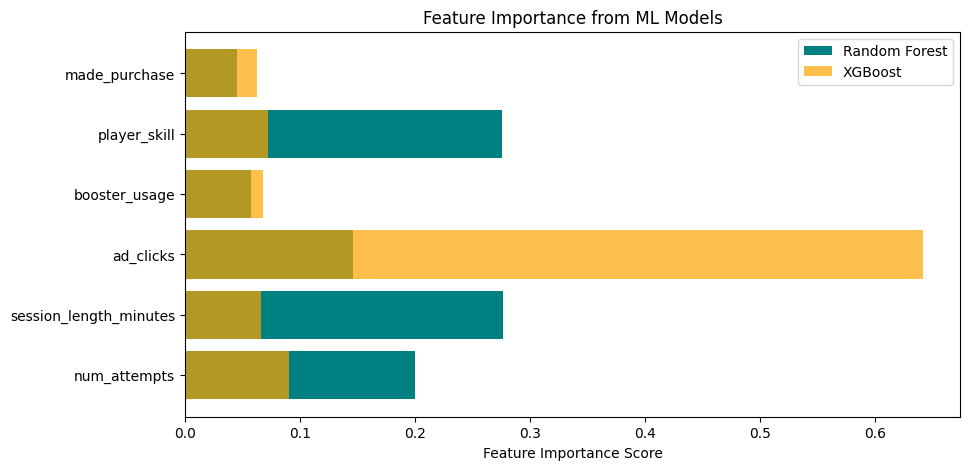

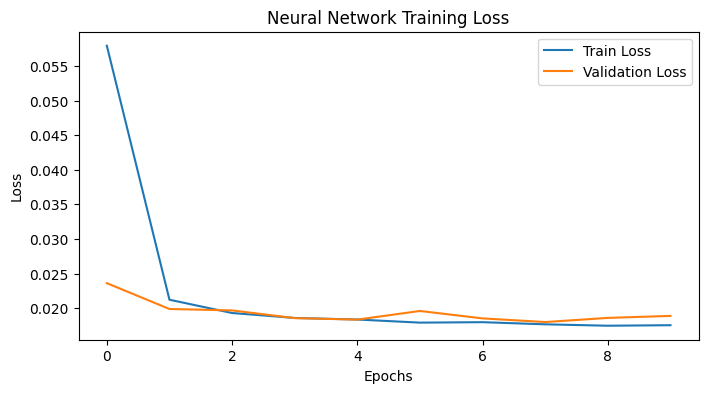

In [ ]:
# 🚀 Step 1: Load Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU

# 🚀 Step 2: Load & Preprocess Time-Series Data
df = pd.read_csv("realistic_synthetic_player_data.csv", parse_dates=["dt"])

# Encode categorical features (if applicable)
df["spender_category"] = LabelEncoder().fit_transform(df["spender_category"])

# Aggregate features per player_id over time
df_grouped = df.groupby("player_id").agg({
    "num_attempts": "sum",
    "session_length_minutes": "mean",
    "ad_clicks": "sum",
    "booster_usage": "sum",
    "player_skill": "mean",
    "made_purchase": "sum",
    "M1_churn": "max",  # Churn Label (1 if churned, 0 if retained)
    "dt": "max"  # Most recent date
}).reset_index()

# Normalize features
scaler = StandardScaler()
features = ["num_attempts", "session_length_minutes", "ad_clicks", "booster_usage", "player_skill", "made_purchase"]
df_grouped[features] = scaler.fit_transform(df_grouped[features])

# Define target & features
X = df_grouped[features]
y = df_grouped["M1_churn"]

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🚀 Step 3: Train ML Models

# ✅ Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# ✅ Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# ✅ XGBoost Model
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# 🚀 Step 4: Train Deep Learning Model
model_nn = Sequential([
    Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model_nn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model_nn.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# 🚀 Step 5: Evaluate & Compare Model Performance
models = {"Logistic Regression": y_pred_lr, "Random Forest": y_pred_rf, "XGBoost": y_pred_xgb}

for name, pred in models.items():
    print(f"🔹 {name} Performance:")
    print(classification_report(y_test, pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, pred)}\n")

# 🚀 Step 6: Evaluate Neural Network
y_pred_nn = (model_nn.predict(X_test) > 0.5).astype(int)
print(f"🔹 Neural Network Performance:")
print(classification_report(y_test, y_pred_nn))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_nn)}\n")

# 🚀 Step 7: Plot Feature Importances (ML Models)
feature_importance_rf = rf_model.feature_importances_
feature_importance_xgb = xgb_model.feature_importances_

plt.figure(figsize=(10, 5))
plt.barh(features, feature_importance_rf, color="teal", label="Random Forest")
plt.barh(features, feature_importance_xgb, color="orange", alpha=0.7, label="XGBoost")
plt.xlabel("Feature Importance Score")
plt.title("Feature Importance from ML Models")
plt.legend()
plt.show()

# 🚀 Step 8: Plot Training Loss for Neural Network
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Neural Network Training Loss")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from sklearn.preprocessing import StandardScaler

# 🚀 **Step 1: Load & Preprocess Data**
df = pd.read_csv("realistic_synthetic_player_data.csv", parse_dates=["dt"])
df.rename(columns={"dt": "date"}, inplace=True)
df.sort_values("date", inplace=True)

# **Handle Missing Values (Avoid Pandas FutureWarning)**
df["M1_churn"] = df["M1_churn"].fillna(df["M1_churn"].median())  # Impute missing values
df.dropna(inplace=True)  # Drop any remaining NaNs

# 📊 **Step 2: Aggregate Churn Rate Per Day**
df["daily_churn"] = df.groupby("date")["M1_churn"].mean()

# 🚀 **Step 3: Normalize Data with StandardScaler**
scaler = StandardScaler()
df["scaled_churn"] = scaler.fit_transform(df[["daily_churn"]].fillna(0))  # Ensure no NaNs

# 📈 **Step 4: Prepare Data for LSTM**
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 30
X, y = create_sequences(df["scaled_churn"].values, sequence_length)

# **Split into Train-Test Sets**
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 🚀 **Step 5: Define LSTM Model with Batch Normalization**
model = Sequential([
    Input(shape=(sequence_length, 1)),  # Explicit Input Layer
    LSTM(50, return_sequences=True),
    BatchNormalization(),  # ✅ Helps with gradient stability
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),
    Dense(25),
    Dense(1, activation="sigmoid")
])

# 🚀 **Step 6: Compile & Train Model with Clipping**
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)  # ✅ Gradient Clipping
model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mae"])

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# 🛠 **Step 7: Plot Loss to Check Training Stability**
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM Training Loss Curve")
plt.legend()
plt.show()


Epoch 1/10
65010/65010 ━━━━━━━━━━━━━━━━━━━━ 2058s 32ms/step - loss: 9.2452e-04 - mae: 0.0039 - val_loss: 4.2687e-13 - val_mae: 6.5346e-07
Epoch 2/10
 1404/65010 ━━━━━━━━━━━━━━━━━━━━ 29:21 28ms/step - loss: 3.5906e-12 - mae: 1.1016e-06

KeyboardInterrupt: 

In [ ]:
! pip install dowhy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.8 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.12
    Uninstalling Cython-3.0.12:
      Successfully uninstalled Cython-3.0.12


<Figure size 1000x600 with 0 Axes>

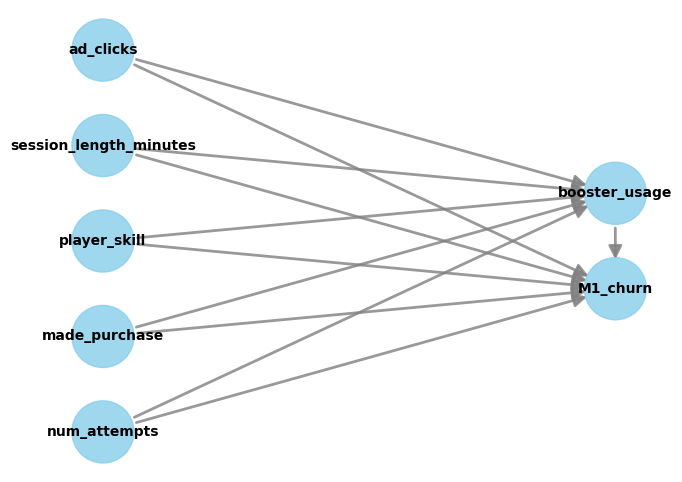

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


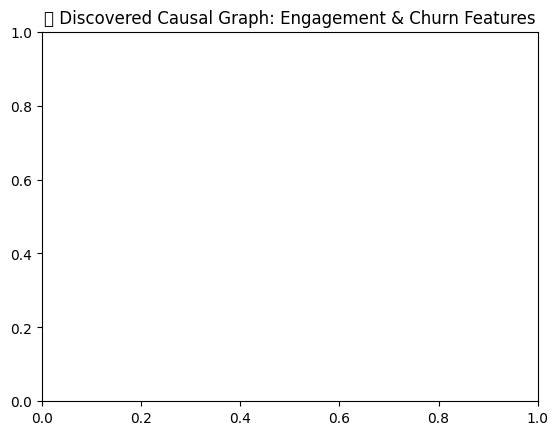

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from dowhy import CausalModel

# 🚀 **Step 1: Load & Preprocess Data**
df = pd.read_csv("realistic_synthetic_player_data.csv", parse_dates=["dt"])
df.rename(columns={"dt": "date"}, inplace=True)
df.sort_values("date", inplace=True)

# **Select Features for Causal Discovery**
causal_features = [
    "num_attempts", "session_length_minutes", "booster_usage",
    "player_skill", "made_purchase", "ad_clicks", "M1_churn"
]
df_causal = df[causal_features].dropna()  # Drop NaNs

# 🚀 **Step 2: Create a Causal Model in DoWhy**
model = CausalModel(
    data=df_causal,
    treatment="booster_usage",
    outcome="M1_churn",
    common_causes=["num_attempts", "session_length_minutes", "player_skill", "made_purchase", "ad_clicks"]
)

# 🎯 **Step 3: Visualize the Causal Graph**
plt.figure(figsize=(10, 6))
model.view_model()
plt.title("🔍 Discovered Causal Graph: Engagement & Churn Features")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from dowhy import CausalModel

# 🚀 Step 1: Load & Preprocess Data
df = pd.read_csv("realistic_synthetic_player_data.csv", parse_dates=["dt"])
df.rename(columns={"dt": "date"}, inplace=True)
df.sort_values("date", inplace=True)

# Normalize relevant features
scaler = MinMaxScaler()
df[["num_attempts", "session_length_minutes", "player_skill", "booster_usage"]] = scaler.fit_transform(
    df[["num_attempts", "session_length_minutes", "player_skill", "booster_usage"]]
)

# Define features and target variables
features = ["num_attempts", "session_length_minutes", "player_skill", "booster_usage"]
target = "M1_churn"

df["action"] = df["booster_usage"]  # Define action as booster usage

# 🚀 Step 2: Causal Discovery
model = CausalModel(
    data=df,
    treatment="action",
    outcome=target,
    common_causes=features,
)
identified_estimand = model.identify_effect()

df["reward"] = -df[target]  # Reward is negative if churn occurs

# 🚀 Step 3: Define the CRL Environment
class ChurnEnvironment:
    def __init__(self, df, features, action_col, reward_col):
        self.df = df.copy()
        self.features = features
        self.action_col = action_col
        self.reward_col = reward_col
        self.current_index = 0

    def reset(self):
        self.current_index = 0
        return self.df[self.features].iloc[self.current_index].values

    def step(self, action):
        self.df.loc[self.current_index, self.action_col] = action
        reward = self.df.loc[self.current_index, self.reward_col]
        self.current_index += 1
        done = self.current_index >= len(self.df)
        next_state = self.df[self.features].iloc[self.current_index].values if not done else np.zeros(len(self.features))
        return next_state, reward, done

env = ChurnEnvironment(df, features, "action", "reward")

# 🚀 Step 4: Define CRL Agent
class CRLAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Dense(24, input_dim=self.state_size, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(np.array([state]), verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size=32):
        minibatch = random.sample(self.memory, min(batch_size, len(self.memory)))
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(np.array([next_state]), verbose=0)[0])
            target_f = self.model.predict(np.array([state]), verbose=0)
            target_f[0][action] = target
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# 🚀 Step 5: Train the CRL Agent
state_size = len(features)
action_size = 2  # Boosters: 0 (No Boost) or 1 (Boost)
agent = CRLAgent(state_size, action_size)
episodes = 50

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    agent.replay()
    print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}")

# 🚀 Step 6: Evaluate the Policy
state = env.reset()
done = False
total_reward = 0

while not done:
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    state = next_state
    total_reward += reward

print(f"Final Policy Total Reward: {total_reward}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
!pip install tqdm

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from dowhy import CausalModel

# 🚀 Step 1: Load & Preprocess Data
df = pd.read_csv("realistic_synthetic_player_data.csv", parse_dates=["dt"])
df.rename(columns={"dt": "date"}, inplace=True)
df.sort_values("date", inplace=True)

# Normalize relevant features
scaler = MinMaxScaler()
df[["num_attempts", "session_length_minutes", "player_skill", "booster_usage"]] = scaler.fit_transform(
    df[["num_attempts", "session_length_minutes", "player_skill", "booster_usage"]]
)

# Define features and target variables
features = ["num_attempts", "session_length_minutes", "player_skill", "booster_usage"]
target = "M1_churn"
df["action"] = df["booster_usage"]  # Define action as booster usage

# 🚀 Step 2: Causal Discovery
model = CausalModel(
    data=df,
    treatment="action",
    outcome=target,
    common_causes=features,
)
identified_estimand = model.identify_effect()
df["reward"] = -df[target]  # Reward is negative if churn occurs

# 🚀 Step 3: Define CRL Environment
class ChurnEnvironment:
    def __init__(self, df, features, action_col, reward_col):
        self.df = df.copy()
        self.features = features
        self.action_col = action_col
        self.reward_col = reward_col
        self.current_index = 0

    def reset(self):
        self.current_index = 0
        return self.df[self.features].iloc[self.current_index].values

    def step(self, action):
        self.df.loc[self.current_index, self.action_col] = action
        reward = self.df.loc[self.current_index, self.reward_col]
        self.current_index += 1
        done = self.current_index >= len(self.df)
        next_state = self.df[self.features].iloc[self.current_index].values if not done else np.zeros(len(self.features))
        return next_state, reward, done

env = ChurnEnvironment(df, features, "action", "reward")

# 🚀 Step 4: Define CRL Agent with Disk-Based Experience Replay
class CRLAgent:
    def __init__(self, state_size, action_size, buffer_size=10000, batch_size=64):
        self.state_size = state_size
        self.action_size = action_size
        self.memory_file = "memory_buffer.npy"
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001

        # Memory-mapped buffer for experience replay (state, action, reward, next_state, done)
        self.memory = np.memmap(self.memory_file, dtype=np.float32, mode='w+', shape=(self.buffer_size, state_size * 2 + 3))

        self.current_index = 0  # Tracks where to write in memory
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Dense(32, input_dim=self.state_size, activation='relu'),
            Dense(32, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        """ Store experience in memory-mapped file """
        experience = np.hstack((state, action, reward, next_state, done))
        self.memory[self.current_index] = experience
        self.current_index = (self.current_index + 1) % self.buffer_size  # Circular buffer

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(np.array([state]), verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        """ Load batch from disk & train """
        if self.current_index < self.batch_size:
            return  # Not enough samples yet

        sample_indices = np.random.choice(min(self.current_index, self.buffer_size), self.batch_size, replace=False)
        batch = self.memory[sample_indices]

        X_train, Y_train = [], []
        for exp in batch:
            state = exp[:self.state_size]
            action = int(exp[self.state_size])
            reward = exp[self.state_size + 1]
            next_state = exp[self.state_size + 2:-1]
            done = exp[-1]

            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(np.array([next_state]), verbose=0)[0])
            target_f = self.model.predict(np.array([state]), verbose=0)
            target_f[0][action] = target
            X_train.append(state)
            Y_train.append(target_f[0])

        self.model.fit(np.array(X_train), np.array(Y_train), epochs=1, verbose=0, batch_size=self.batch_size)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# 🚀 Step 5: Train the CRL Agent with Disk-Based Memory
state_size = len(features)
action_size = 2  # Boosters: 0 (No Boost) or 1 (Boost)
agent = CRLAgent(state_size, action_size)
episodes = 50

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    agent.replay()  # Load batch from disk and train
    print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}")

# 🚀 Step 6: Evaluate the Policy
state = env.reset()
done = False
total_reward = 0

while not done:
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    state = next_state
    total_reward += reward

print(f"Final Policy Total Reward: {total_reward}")

# Clean up memory-mapped file after training (optional)
os.remove("memory_buffer.npy")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

# 📌 Define Dataset Size
num_players = 100_000  # 100K unique players
num_days = 365  # Data for 1 year
max_levels = 100  # Levels range from 1 to 100

# 📌 Generate Player IDs
player_ids = [f"player_{i}" for i in range(num_players)]

# 📌 Generate Start Dates for Players
start_dates = np.random.choice(pd.date_range("2023-01-01", "2023-12-31"), size=num_players)

# 📌 Initialize Data
data = []

for player_id, start_date in zip(player_ids, start_dates):
    num_sessions = np.random.randint(5, 100)  # Each player plays multiple sessions
    session_dates = sorted(
        np.random.choice(pd.date_range(start_date, "2024-01-01"), size=num_sessions, replace=True)
    )

    # Assign **Player Skill** (affects level progression & churn)
    player_skill = np.random.uniform(0.1, 1.0)  # Higher skill → higher level, lower churn

    for session_date in session_dates:
        level = min(max_levels, int(1 + max_levels * player_skill * np.random.rand()))

        # 📌 Session Timing (More Evening Playtime)
        hour_probs = np.array([0.02, 0.02, 0.01, 0.01, 0.02, 0.02, 0.03, 0.05, 0.08, 0.10,
                               0.12, 0.12, 0.10, 0.08, 0.08, 0.08, 0.07, 0.05, 0.03, 0.02,
                               0.02, 0.02, 0.01, 0.01])
        hour_probs /= hour_probs.sum()  # Normalize
        hour = int(np.random.choice(range(24), p=hour_probs))
        session_time = pd.Timestamp(session_date) + pd.to_timedelta(hour, unit="h") + pd.to_timedelta(np.random.randint(0, 60), unit="m")

        # 📌 Adaptive Attempts Based on Difficulty & Skill
        base_attempts = np.random.randint(1, 20)
        num_attempts = max(1, int(base_attempts * (1.2 - player_skill)))
        num_success = max(0, int(np.random.uniform(0.3 + player_skill * 0.4, 1.0) * num_attempts))
        failed_first_attempt = 1 if num_success == 0 else 0

        # 📌 **Session Length → Depends on Level & Attempts**
        session_length_minutes = max(1, np.random.normal(20 + level * 0.5 - player_skill * 10, 10))

        # 📌 **Ad Clicks** → Struggling players watch more ads
        ad_clicks = np.random.poisson(1 if num_success > 0 else 4)  # Unsuccessful players click more ads

        # 📌 **Booster Usage → Depends on Difficulty & Spending**
        booster_usage = np.random.randint(1, 4) if num_attempts > 10 and np.random.rand() < 0.5 else 0

        # 📌 **Spending Model**
        made_purchase = np.random.choice([0, 1], p=[0.90, 0.10])  # 10% players make purchases
        power_up_purchase = np.random.choice([0, 1], p=[0.95, 0.05])

        # Spending Category (More skilled players tend to be spenders)
        if made_purchase:
            spender_category = np.random.choice(["Low-Spender", "High-Spender"], p=[0.8, 0.2])
        else:
            spender_category = "Non-Spender"

        # Append to dataset
        data.append([
            player_id, session_time, level, num_attempts, num_success, failed_first_attempt,
            session_length_minutes, made_purchase, spender_category, power_up_purchase,
            booster_usage, ad_clicks, player_skill
        ])

# 📌 Create DataFrame
df = pd.DataFrame(data, columns=[
    "player_id", "dt", "level", "num_attempts", "num_success", "failed_first_attempt",
    "session_length_minutes", "made_purchase", "spender_category", "power_up_purchase",
    "booster_usage", "ad_clicks", "player_skill"
])

# 📌 Compute Days Since First Play
df["dt"] = pd.to_datetime(df["dt"])
df["first_play_date"] = df.groupby("player_id")["dt"].transform("min")
df["days_since_first_play"] = (df["dt"] - df["first_play_date"]).dt.days

# 📌 Compute Total Levels Played
df["total_levels_played"] = df.groupby("player_id")["level"].transform("nunique")

# 📌 **Churn Model (Realistic Probabilities)**
engagement_score = df["num_attempts"] * 0.5 - df["session_length_minutes"] * 0.05 + df["player_skill"] * 2
churn_prob = np.clip(0.5 - (engagement_score / 50), 0.05, 0.9)  # Players with better engagement have lower churn

df["churned"] = np.random.binomial(1, churn_prob)

# **Day-wise & Month-wise Churn**
for d in range(1, 8):
    df[f"D{d}_churn"] = np.random.binomial(1, churn_prob * (0.9 - d * 0.1))  # Lower churn the longer they stay

for m in range(1, 13):
    df[f"M{m}_churn"] = np.random.binomial(1, churn_prob * (0.8 - m * 0.05))

# 📌 **Sort & Save**
df = df.sort_values(by=["player_id", "dt"])
df.to_csv("realistic_synthetic_player_data.csv", index=False)

# 📊 Show Sample
print(df.head())



  player_id                  dt  level  num_attempts  num_success  \
0  player_0 2023-04-13 07:23:00      6            13           12   
1  player_0 2023-04-24 08:23:00     19             5            2   
2  player_0 2023-04-26 11:47:00     18             5            4   
3  player_0 2023-05-04 22:59:00     13             5            3   
5  player_0 2023-05-09 03:32:00      4             8            5   

   failed_first_attempt  session_length_minutes  made_purchase  \
0                     0               27.868874              0   
1                     0               23.387788              0   
2                     0               34.749714              0   
3                     0               38.766103              0   
5                     0               16.109370              0   

  spender_category  power_up_purchase  ...  M3_churn  M4_churn  M5_churn  \
0      Non-Spender                  0  ...         0         0         1   
1      Non-Spender                  

In [ ]:
import pandas as pd

df = pd.read_csv("realistic_synthetic_player_data.csv")
print(df.columns)


Index(['player_id', 'dt', 'level', 'num_attempts', 'num_success',
       'failed_first_attempt', 'session_length_minutes', 'made_purchase',
       'spender_category', 'power_up_purchase', 'booster_usage', 'ad_clicks',
       'player_skill', 'first_play_date', 'days_since_first_play',
       'total_levels_played', 'churned', 'D1_churn', 'D2_churn', 'D3_churn',
       'D4_churn', 'D5_churn', 'D6_churn', 'D7_churn', 'M1_churn', 'M2_churn',
       'M3_churn', 'M4_churn', 'M5_churn', 'M6_churn', 'M7_churn', 'M8_churn',
       'M9_churn', 'M10_churn', 'M11_churn', 'M12_churn'],
      dtype='object')


<ipython-input-3-fc318cc4b289>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train, X_test = X[train_mask], X[test_mask]
<ipython-input-3-fc318cc4b289>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train, X_test = X[train_mask], X[test_mask]


<Figure size 1000x600 with 0 Axes>

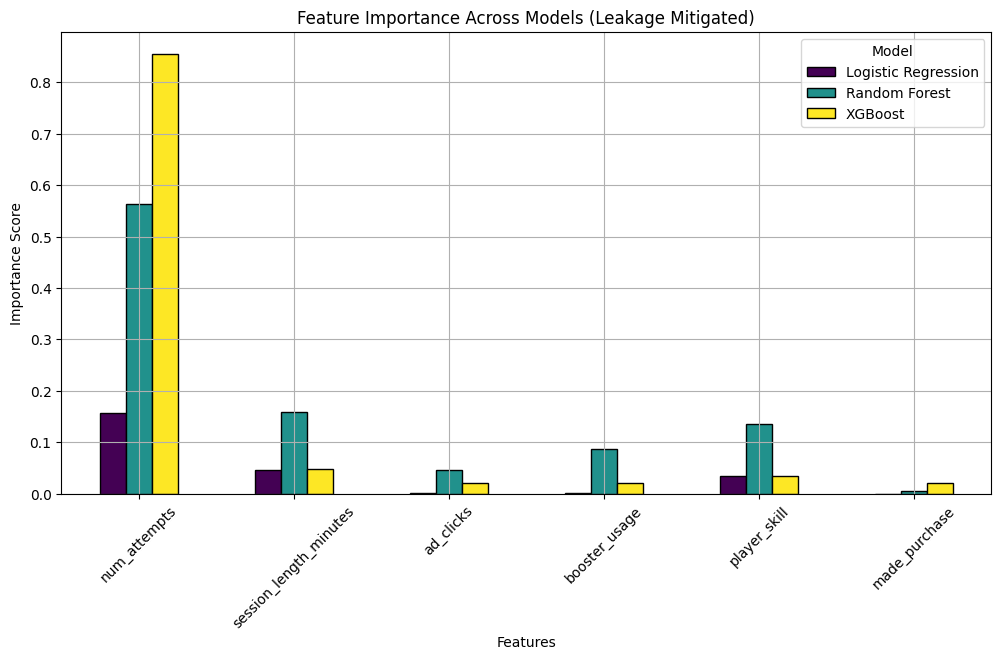

✅ **XGBoost Cross-Validation AUC: 0.5414 ± 0.0005**


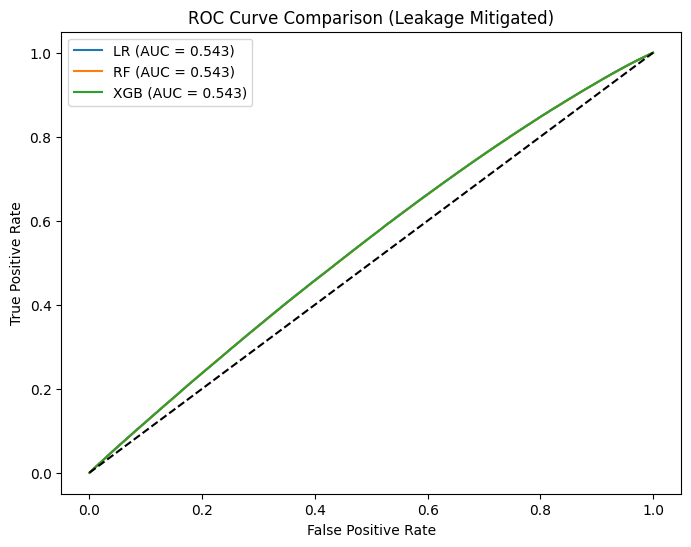

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, f1_score
import xgboost as xgb
import scipy.stats as stats

# 📌 **Step 1: Load Dataset (Ensure No Future Data is Used)**
df = pd.read_csv("realistic_synthetic_player_data.csv")

# 📌 **Step 2: Identify and Remove Leaky Features**
# Features like 'churned' or cumulative stats may contain direct information about the target
potential_leak_features = ["churned", "total_levels_played", "days_since_first_play"]
df.drop(columns=[col for col in potential_leak_features if col in df.columns], inplace=True)

# 📌 **Step 3: Define Features & Target**
features = ["num_attempts", "session_length_minutes", "ad_clicks", "booster_usage", "player_skill", "made_purchase"]
target = "M1_churn"

# 📌 **Step 4: Proper Train-Test Split Before Scaling (Avoid Leakage)**
X = df[features]
y = df[target]

# **Ensure test data is from the future (Simulating Deployment)**
df["dt"] = pd.to_datetime(df["dt"])
df.sort_values("dt", inplace=True)  # Sort by date to simulate real-world training/test separation

split_date = df["dt"].quantile(0.8)  # Use 80% of earliest data for training, 20% latest for testing
train_mask = df["dt"] < split_date
test_mask = df["dt"] >= split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# ✅ **Scaling (Only Fit on Training Data)**
scaler_lr = StandardScaler()  # Standardization for LR
scaler_tree = MinMaxScaler()  # Normalization for RF & XGBoost

X_train_scaled_lr = scaler_lr.fit_transform(X_train)
X_test_scaled_lr = scaler_lr.transform(X_test)  # **Avoid refitting on test set**

X_train_scaled_tree = scaler_tree.fit_transform(X_train)
X_test_scaled_tree = scaler_tree.transform(X_test)

# 📌 **Step 5: Train Logistic Regression (L2 Regularization)**
lr_model = LogisticRegression(C=0.1, penalty="l2", solver="liblinear")
lr_model.fit(X_train_scaled_lr, y_train)
lr_importance = np.abs(lr_model.coef_).flatten()

# 📌 **Step 6: Train Random Forest**
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, class_weight="balanced")
rf_model.fit(X_train_scaled_tree, y_train)
rf_importance = rf_model.feature_importances_

# 📌 **Step 7: Train XGBoost (Boosting)**
xgb_model = xgb.XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=6, subsample=0.7, reg_lambda=1.0, random_state=42)
xgb_model.fit(X_train_scaled_tree, y_train)
xgb_importance = xgb_model.feature_importances_

# 📌 **Step 8: Combine Feature Importances**
importance_df = pd.DataFrame({
    "Feature": features,
    "Logistic Regression": lr_importance,
    "Random Forest": rf_importance,
    "XGBoost": xgb_importance
}).set_index("Feature")

# 📌 **Step 9: Plot Feature Importance**
plt.figure(figsize=(10,6))
importance_df.plot(kind="bar", figsize=(12,6), colormap="viridis", edgecolor="black")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Feature Importance Across Models (Leakage Mitigated)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Model")
plt.show()

# 📌 **Step 10: Validate with Cross-Validation**
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_cv_score = cross_val_score(xgb_model, X_train_scaled_tree, y_train, cv=cv, scoring="roc_auc")
print(f"✅ **XGBoost Cross-Validation AUC: {np.mean(xgb_cv_score):.4f} ± {np.std(xgb_cv_score):.4f}**")

# 📌 **Step 11: Evaluate on Test Data with ROC Curve**
lr_probs = lr_model.predict_proba(X_test_scaled_lr)[:, 1]
rf_probs = rf_model.predict_proba(X_test_scaled_tree)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test_scaled_tree)[:, 1]

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, lr_probs)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_probs)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_probs)

roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# 📌 **Plot ROC Curve**
plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC = {roc_auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC = {roc_auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB (AUC = {roc_auc_xgb:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Leakage Mitigated)")
plt.legend()
plt.show()
